# Performance PR Analysis: AI Agents vs Humans

## Comprehensive Analysis of Performance Optimization PRs

This notebook addresses all research questions comparing AI coding agents and human developers on performance optimization tasks:

### 1. **Adoption and Practices**

- What practices (e.g., PR size, task type, and commit granularity) correlate with the quality of **performance optimization commits**?
    - How can these practices inform **guidelines for developers and AI agents** to produce effective and efficient performance-improving patches?
- Which programming languages most frequently appear in performance-improving tasks?

### 2. **Optimization Patch Characteristics**

- How do performance-oriented code patches modify software structure (e.g., changes in loops, data structures, parallelization, or algorithmic complexity; additions, deletions, files touched)?
- What are the implications for maintainability?

### 3. **Testing and Evaluation Behavior**

- How do AI agents **measure and validate performance improvements** (e.g., benchmarks, profiling metrics, unit tests)?
- How frequently and systematically are performance tests executed after code optimization?

### 4. **Review Dynamics**

- Do **performance-optimizing pull requests** receive distinctive review attention (e.g., profiling validation, discussion of tradeoffs)?
- What kinds of review comments (e.g., correctness, maintainability, performance tradeoffs) are most associated with optimization patches?

### 5. **Failure Patterns and Risks**

- What **common failure patterns** and code quality issues appear in optimization-oriented PRs?
- Why do these failures occur, and how can insights from them be used to **improve automated optimization systems and human–AI collaboration**?

## Setup and Data Loading

In [43]:
# Install dependencies
!pip install pandas numpy matplotlib seaborn scipy wordcloud pyarrow datasets --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
from collections import Counter
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment ready!")


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Environment ready!


In [44]:
# Load datasets
print("Loading AIDev datasets...")

# AI Agent PRs
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")
ai_perf_prs = (
    pr_df
    .merge(
        pr_task_type_df[["id", "type", "reason"]],
        on="id",
        how="inner"
    )
    .query("type == 'perf'")
    .copy()
)
ai_perf_prs['classification_reason'] = ai_perf_prs['reason']
ai_perf_prs['author_type'] = 'AI Agent'

# Human PRs
human_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pull_request.parquet")
human_pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pr_task_type.parquet")
human_perf_prs = (
    human_pr_df
    .merge(
        human_pr_task_type_df[["id", "type", "reason"]],
        on="id",
        how="inner"
    )
    .query("type == 'perf'")
    .copy()
)
human_perf_prs['classification_reason'] = human_perf_prs['reason']
human_perf_prs['author_type'] = 'Human'
human_perf_prs['agent'] = 'Human'  # Add agent column for consistency

# Repository data for language info
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")

# Get list of performance PR IDs we care about
perf_pr_ids = set(ai_perf_prs['id'].tolist() + human_perf_prs['id'].tolist())
print(f"\n✓ Performance PR IDs to process: {len(perf_pr_ids):,}")

# PR commits details - FILTER FIRST, then aggregate
print("\nProcessing commit details (filtering to performance PRs only)...")
pr_commits_details = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")

if 'pr_id' in pr_commits_details.columns:
    print(f"  Total commit records in dataset: {len(pr_commits_details):,}")
    
    # FILTER: Keep only commits for performance PRs
    pr_commits_filtered = pr_commits_details[pr_commits_details['pr_id'].isin(perf_pr_ids)].copy()
    print(f"  Filtered to performance PRs: {len(pr_commits_filtered):,} commit records")
    print(f"  Unique performance PRs with commits: {pr_commits_filtered['pr_id'].nunique():,}")
    
    if len(pr_commits_filtered) > 0:
        # AGGREGATE: Now aggregate only the filtered commits
        commit_aggregated = pr_commits_filtered.groupby('pr_id').agg({
            'additions': 'sum',      # Total lines added across all commits
            'deletions': 'sum',      # Total lines deleted across all commits
            'patch': lambda x: '\n\n'.join([str(p) for p in x if pd.notna(p)])  # Concatenate all patches
        }).reset_index()
        
        # Add derived metrics
        commit_aggregated['num_commits'] = pr_commits_filtered.groupby('pr_id').size().values
        
        # Calculate patch length (for analysis)
        commit_aggregated['patch_length'] = commit_aggregated['patch'].str.len()
        
        print(f"  ✓ Aggregated to {len(commit_aggregated):,} unique performance PRs")
        print(f"  Avg commits per PR: {commit_aggregated['num_commits'].mean():.1f}")
        
        # Merge commit stats into AI Agent PR table
        ai_perf_prs = ai_perf_prs.merge(
            commit_aggregated,
            left_on='id',
            right_on='pr_id',
            how='left'
        )
        if 'pr_id' in ai_perf_prs.columns:
            ai_perf_prs = ai_perf_prs.drop(columns=['pr_id'])
        
        ai_with_commits = ai_perf_prs['additions'].notna().sum()
        print(f"  AI Agent PRs with commit data: {ai_with_commits:,} / {len(ai_perf_prs):,} ({ai_with_commits/len(ai_perf_prs)*100:.1f}%)")
        
        # Merge commit stats into Human PR table
        human_perf_prs = human_perf_prs.merge(
            commit_aggregated,
            left_on='id',
            right_on='pr_id',
            how='left'
        )
        if 'pr_id' in human_perf_prs.columns:
            human_perf_prs = human_perf_prs.drop(columns=['pr_id'])
        
        human_with_commits = human_perf_prs['additions'].notna().sum()
        print(f"  Human PRs with commit data: {human_with_commits:,} / {len(human_perf_prs):,} ({human_with_commits/len(human_perf_prs)*100:.1f}%)")
    else:
        print("  ⚠ No commits found for performance PRs")
        # Add placeholder columns
        for df in [ai_perf_prs, human_perf_prs]:
            df['additions'] = None
            df['deletions'] = None
            df['num_commits'] = None
            df['patch'] = None
            df['patch_length'] = None
    
else:
    print('⚠ pr_commit_details missing pr_id column; skipping commit merges.')
    # Add placeholder columns
    for df in [ai_perf_prs, human_perf_prs]:
        df['additions'] = None
        df['deletions'] = None
        df['num_commits'] = None
        df['patch'] = None
        df['patch_length'] = None

print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}")
print(f"✓ AI Agent Performance PRs: {len(ai_perf_prs):,}")
print(f"✓ Human Performance PRs: {len(human_perf_prs):,}")
print(f"✓ Total Performance PRs: {len(ai_perf_prs) + len(human_perf_prs):,}")

# Distribution by AI agent
print(f"\nAI Agent Distribution:")
for agent, count in ai_perf_prs['agent'].value_counts().items():
    pct = count / len(ai_perf_prs) * 100
    print(f"  {agent:20s} {count:5,d} ({pct:5.1f}%)")

# Commit statistics summary
if 'num_commits' in ai_perf_prs.columns and ai_perf_prs['num_commits'].notna().any():
    print(f"\n{'='*80}")
    print(f"COMMIT STATISTICS")
    print(f"{'='*80}")
    
    for author_type, df in [('AI Agent', ai_perf_prs), ('Human', human_perf_prs)]:
        with_commits = df['num_commits'].notna()
        if with_commits.sum() > 0:
            print(f"\n{author_type}:")
            print(f"  PRs with commit data: {with_commits.sum():,} ({with_commits.mean()*100:.1f}%)")
            print(f"  Avg commits per PR: {df.loc[with_commits, 'num_commits'].mean():.1f}")
            print(f"  Median commits per PR: {df.loc[with_commits, 'num_commits'].median():.1f}")
            print(f"  Avg additions: {df.loc[with_commits, 'additions'].mean():.0f} lines")
            print(f"  Median additions: {df.loc[with_commits, 'additions'].median():.0f} lines")
            print(f"  Avg deletions: {df.loc[with_commits, 'deletions'].mean():.0f} lines")
            print(f"  Median deletions: {df.loc[with_commits, 'deletions'].median():.0f} lines")

print(f"\n{'='*80}")

Loading AIDev datasets...

✓ Performance PR IDs to process: 428

Processing commit details (filtering to performance PRs only)...
  Total commit records in dataset: 711,923
  Filtered to performance PRs: 7,410 commit records
  Unique performance PRs with commits: 340
  ✓ Aggregated to 340 unique performance PRs
  Avg commits per PR: 21.8
  AI Agent PRs with commit data: 340 / 340 (100.0%)
  Human PRs with commit data: 0 / 88 (0.0%)

SUMMARY
✓ AI Agent Performance PRs: 340
✓ Human Performance PRs: 88
✓ Total Performance PRs: 428

AI Agent Distribution:
  OpenAI_Codex           207 ( 60.9%)
  Devin                   62 ( 18.2%)
  Copilot                 44 ( 12.9%)
  Cursor                  24 (  7.1%)
  Claude_Code              3 (  0.9%)

COMMIT STATISTICS

AI Agent:
  PRs with commit data: 340 (100.0%)
  Avg commits per PR: 21.8
  Median commits per PR: 4.0
  Avg additions: 646 lines
  Median additions: 72 lines
  Avg deletions: 646 lines
  Median deletions: 26 lines



## Data Preparation and Feature Engineering

In [45]:
# Combine AI and Human PRs
perf_prs = pd.concat([ai_perf_prs, human_perf_prs], ignore_index=True)

print(f"Combined dataset: {len(perf_prs):,} performance PRs")
print(f"  AI Agents: {(perf_prs['author_type'] == 'AI Agent').sum():,}")
print(f"  Humans: {(perf_prs['author_type'] == 'Human').sum():,}")

Combined dataset: 428 performance PRs
  AI Agents: 340
  Humans: 88


In [46]:
# Add language from repository table
print("Loading repository data for language information...")

if 'language' in all_repo_df.columns:
    # For AI Agent PRs: join on repo_id
    ai_mask = perf_prs['author_type'] == 'AI Agent'
    ai_prs = perf_prs[ai_mask].copy()
    human_prs = perf_prs[~ai_mask].copy()
    
    # Join AI PRs using repo_id
    if 'repo_id' in ai_prs.columns:
        ai_prs = ai_prs.merge(
            all_repo_df[['id', 'language']], 
            left_on='repo_id', 
            right_on='id', 
            how='left',
            suffixes=('', '_repo')
        )
        ai_prs['primary_language'] = ai_prs['language']
        if 'id_repo' in ai_prs.columns:
            ai_prs = ai_prs.drop(['id_repo'], axis=1)
        if 'language' in ai_prs.columns:
            ai_prs = ai_prs.drop(['language'], axis=1)
    
    # Join Human PRs using repo_url
    # Human PRs have repo_url, match with url from all_repo_df
    if 'repo_url' in human_prs.columns and 'url' in all_repo_df.columns:
        human_prs = human_prs.merge(
            all_repo_df[['url', 'language']], 
            left_on='repo_url',
            right_on='url',
            how='left',
            suffixes=('', '_repo')
        )
        human_prs['primary_language'] = human_prs['language']
        if 'url' in human_prs.columns:
            human_prs = human_prs.drop(['url'], axis=1)
        if 'language' in human_prs.columns:
            human_prs = human_prs.drop(['language'], axis=1)
    
    # Combine back together
    perf_prs = pd.concat([ai_prs, human_prs], ignore_index=True)
    
    ai_lang_count = perf_prs[perf_prs['author_type'] == 'AI Agent']['primary_language'].notna().sum()
    human_lang_count = perf_prs[perf_prs['author_type'] == 'Human']['primary_language'].notna().sum()
    
    print(f"✓ Language data joined!")
    print(f"  AI Agent PRs with language: {ai_lang_count:,}")
    print(f"  Human PRs with language: {human_lang_count:,}")
    print(f"  Total: {perf_prs['primary_language'].notna().sum():,} PRs with language info")
else:
    perf_prs['primary_language'] = None
    print("⚠ No language column in repository table")

Loading repository data for language information...
✓ Language data joined!
  AI Agent PRs with language: 339
  Human PRs with language: 87
  Total: 426 PRs with language info


In [47]:
# Convert date columns
for col in ['created_at', 'closed_at', 'merged_at']:
    if col in perf_prs.columns:
        perf_prs[col] = pd.to_datetime(perf_prs[col])

# Add derived status columns
perf_prs['is_merged'] = perf_prs['merged_at'].notna()
perf_prs['is_closed'] = perf_prs['closed_at'].notna()
perf_prs['is_open'] = perf_prs['state'] == 'open'

# Calculate time metrics
perf_prs['time_to_close_hours'] = (
    perf_prs['closed_at'] - perf_prs['created_at']
).dt.total_seconds() / 3600

perf_prs['time_to_merge_hours'] = (
    perf_prs['merged_at'] - perf_prs['created_at']
).dt.total_seconds() / 3600

perf_prs['time_to_close_days'] = perf_prs['time_to_close_hours'] / 24
perf_prs['time_to_merge_days'] = perf_prs['time_to_merge_hours'] / 24

# Text metrics
perf_prs['title_length'] = perf_prs['title'].str.len()
perf_prs['title_word_count'] = perf_prs['title'].str.split().str.len()
perf_prs['body_length'] = perf_prs['body'].str.len()
perf_prs['body_word_count'] = perf_prs['body'].str.split().str.len()
perf_prs['has_body'] = perf_prs['body'].notna() & (perf_prs['body'].str.strip() != '')

print("✓ Feature engineering complete")
print(f"  Merge rate: {perf_prs['is_merged'].mean()*100:.1f}%")
print(f"  PRs with descriptions: {perf_prs['has_body'].sum():,} ({perf_prs['has_body'].mean()*100:.1f}%)")

✓ Feature engineering complete
  Merge rate: 57.2%
  PRs with descriptions: 411 (96.0%)


## Optimization Pattern Analysis (Agents vs Human)

Loading data from csv files...
Combined dataset: 428 performance PRs
  AI Agents: 340
  Humans: 88

GENERATING VISUALIZATIONS

OPTIMIZATION PATTERN ANALYSIS SUMMARY

Total PRs Analyzed: 428
  AI Agents: 340
  Humans: 88

Unique Patterns: 8
Unique Sub-Patterns: 22

--------------------------------------------------------------------------------
TOP 5 PATTERNS (OVERALL)
--------------------------------------------------------------------------------
  Code Smells and Structural Simplification                     138 ( 32.2%)
  Algorithm-Level Optimizations                                 123 ( 28.7%)
  Memory and Data Locality Optimizations                        109 ( 25.5%)
  Control-Flow and Branching Optimizations                       30 (  7.0%)
  No Meaningful Change                                           12 (  2.8%)

--------------------------------------------------------------------------------
TOP 5 PATTERNS (AI AGENTS)
------------------------------------------------------

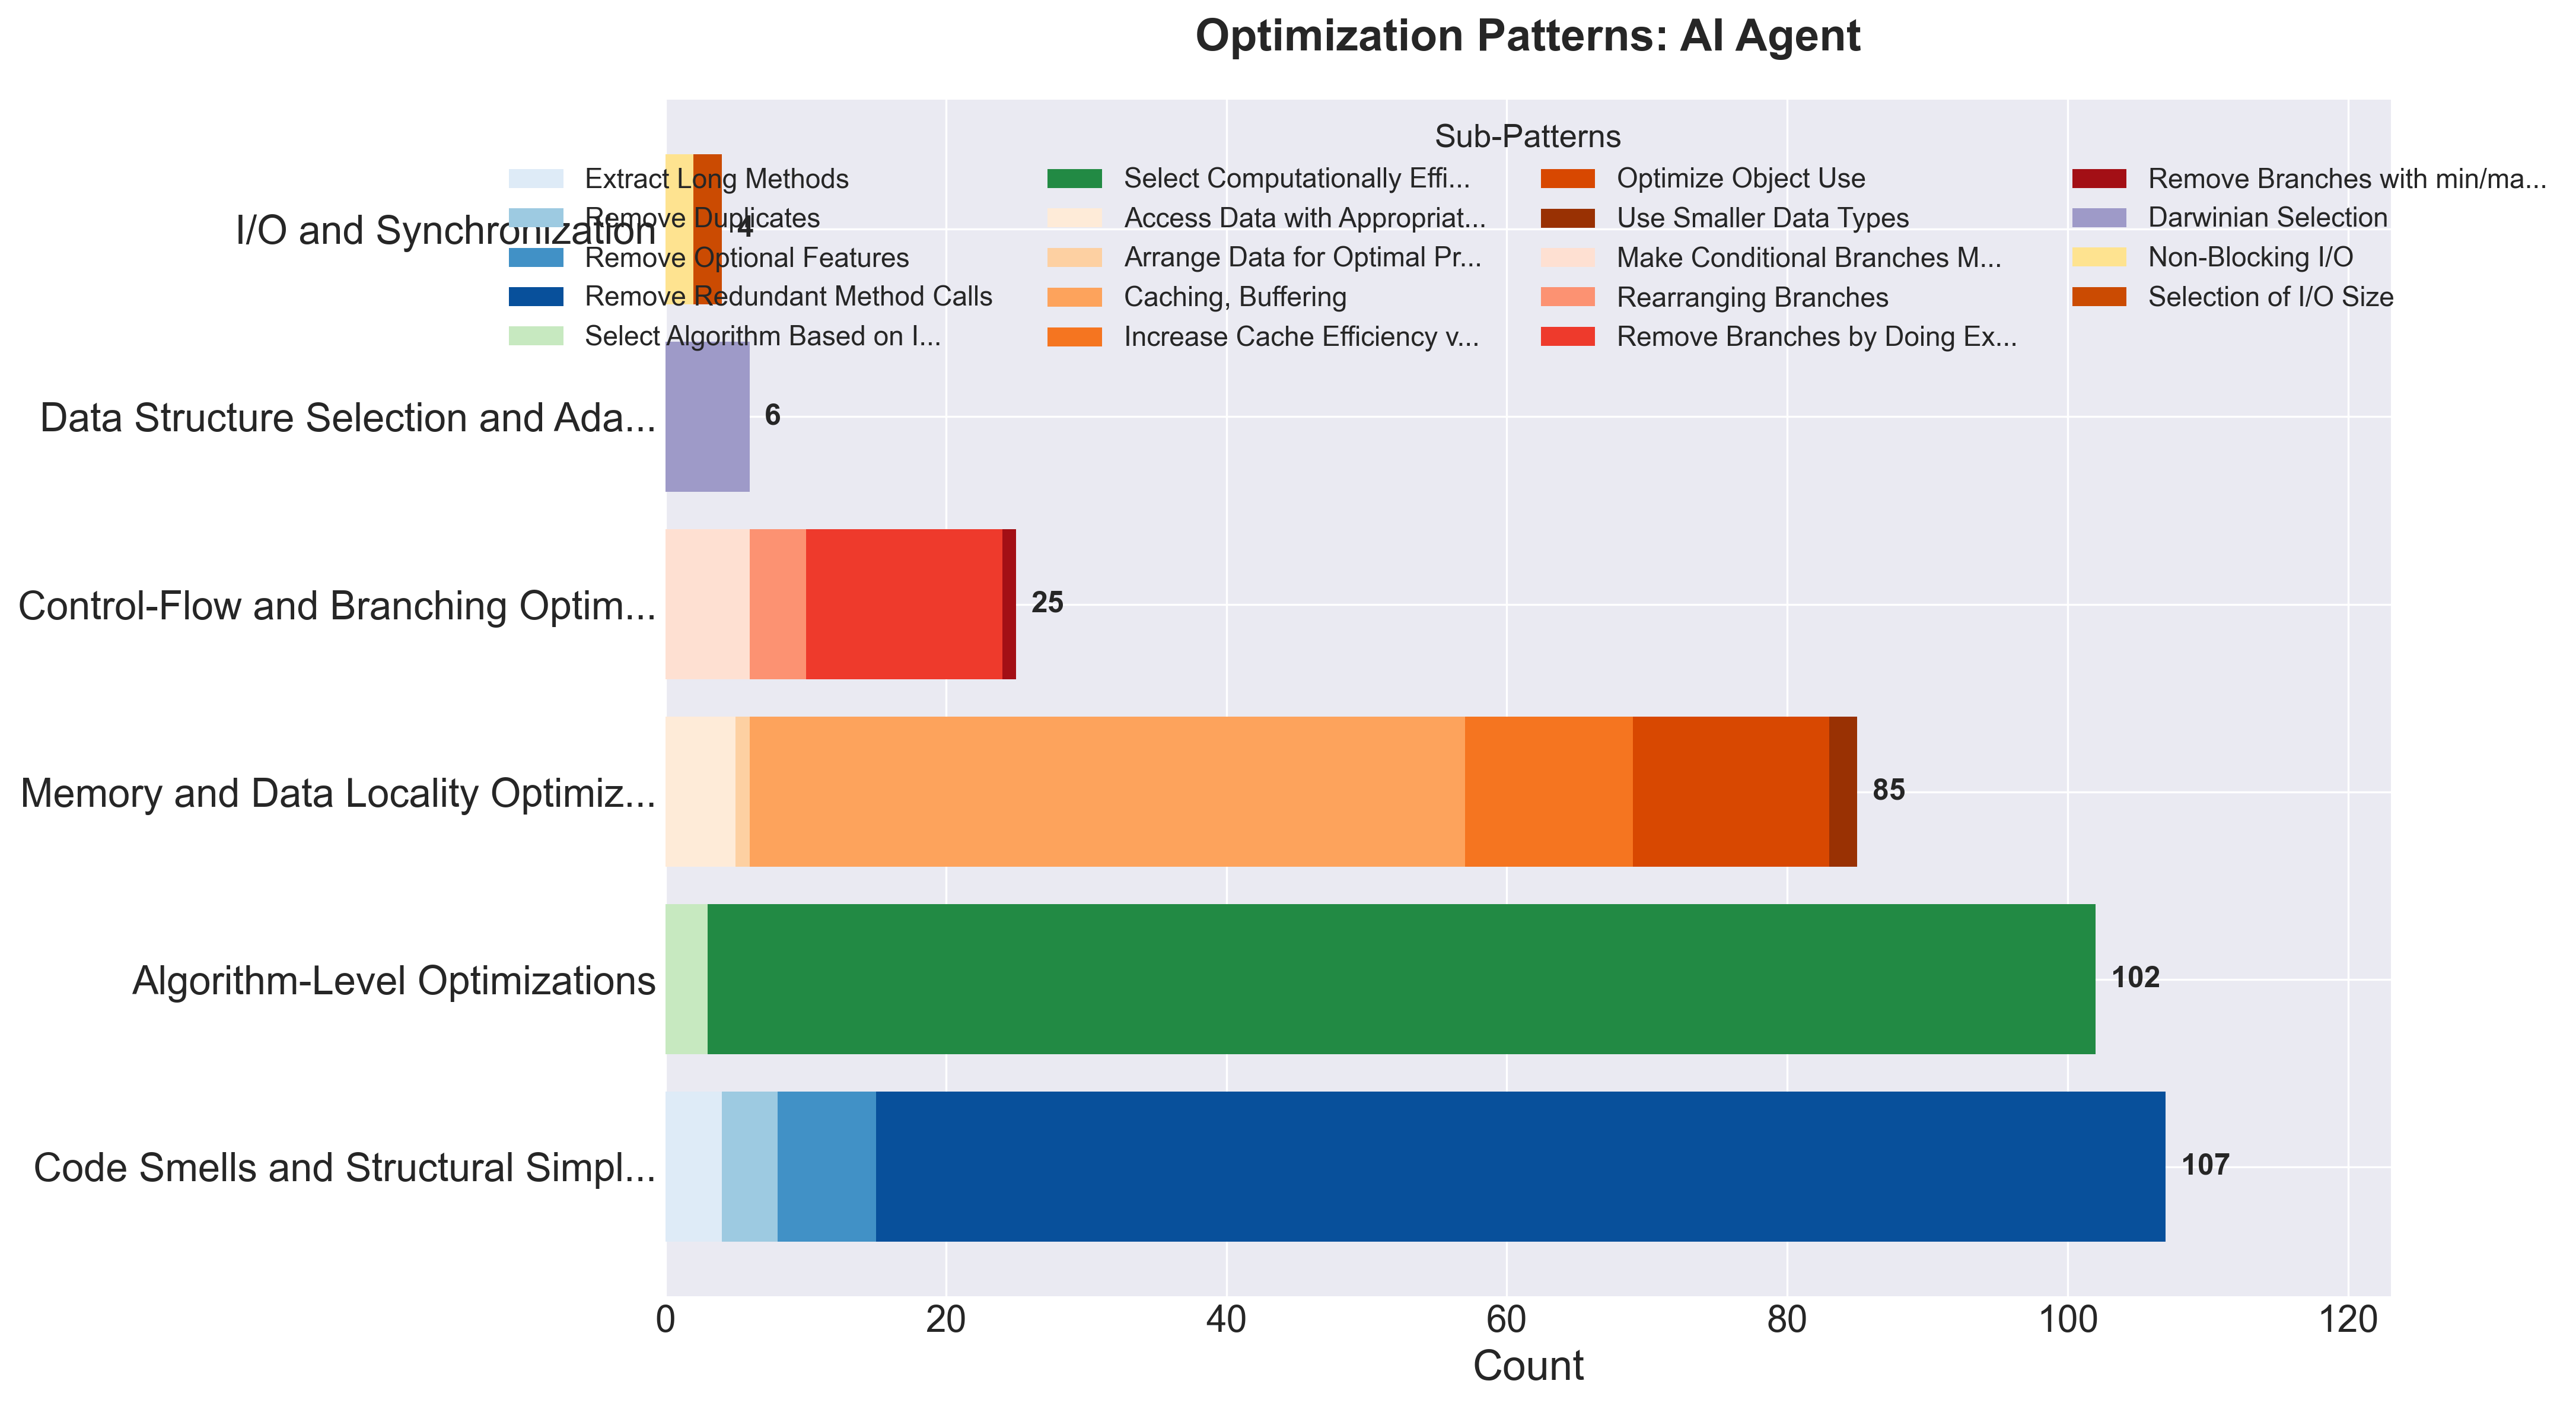

✓ Saved: results/pattern/agent_human/optimization_pattern_ai_agent.png

2. Creating pattern-subpattern distribution for Humans...


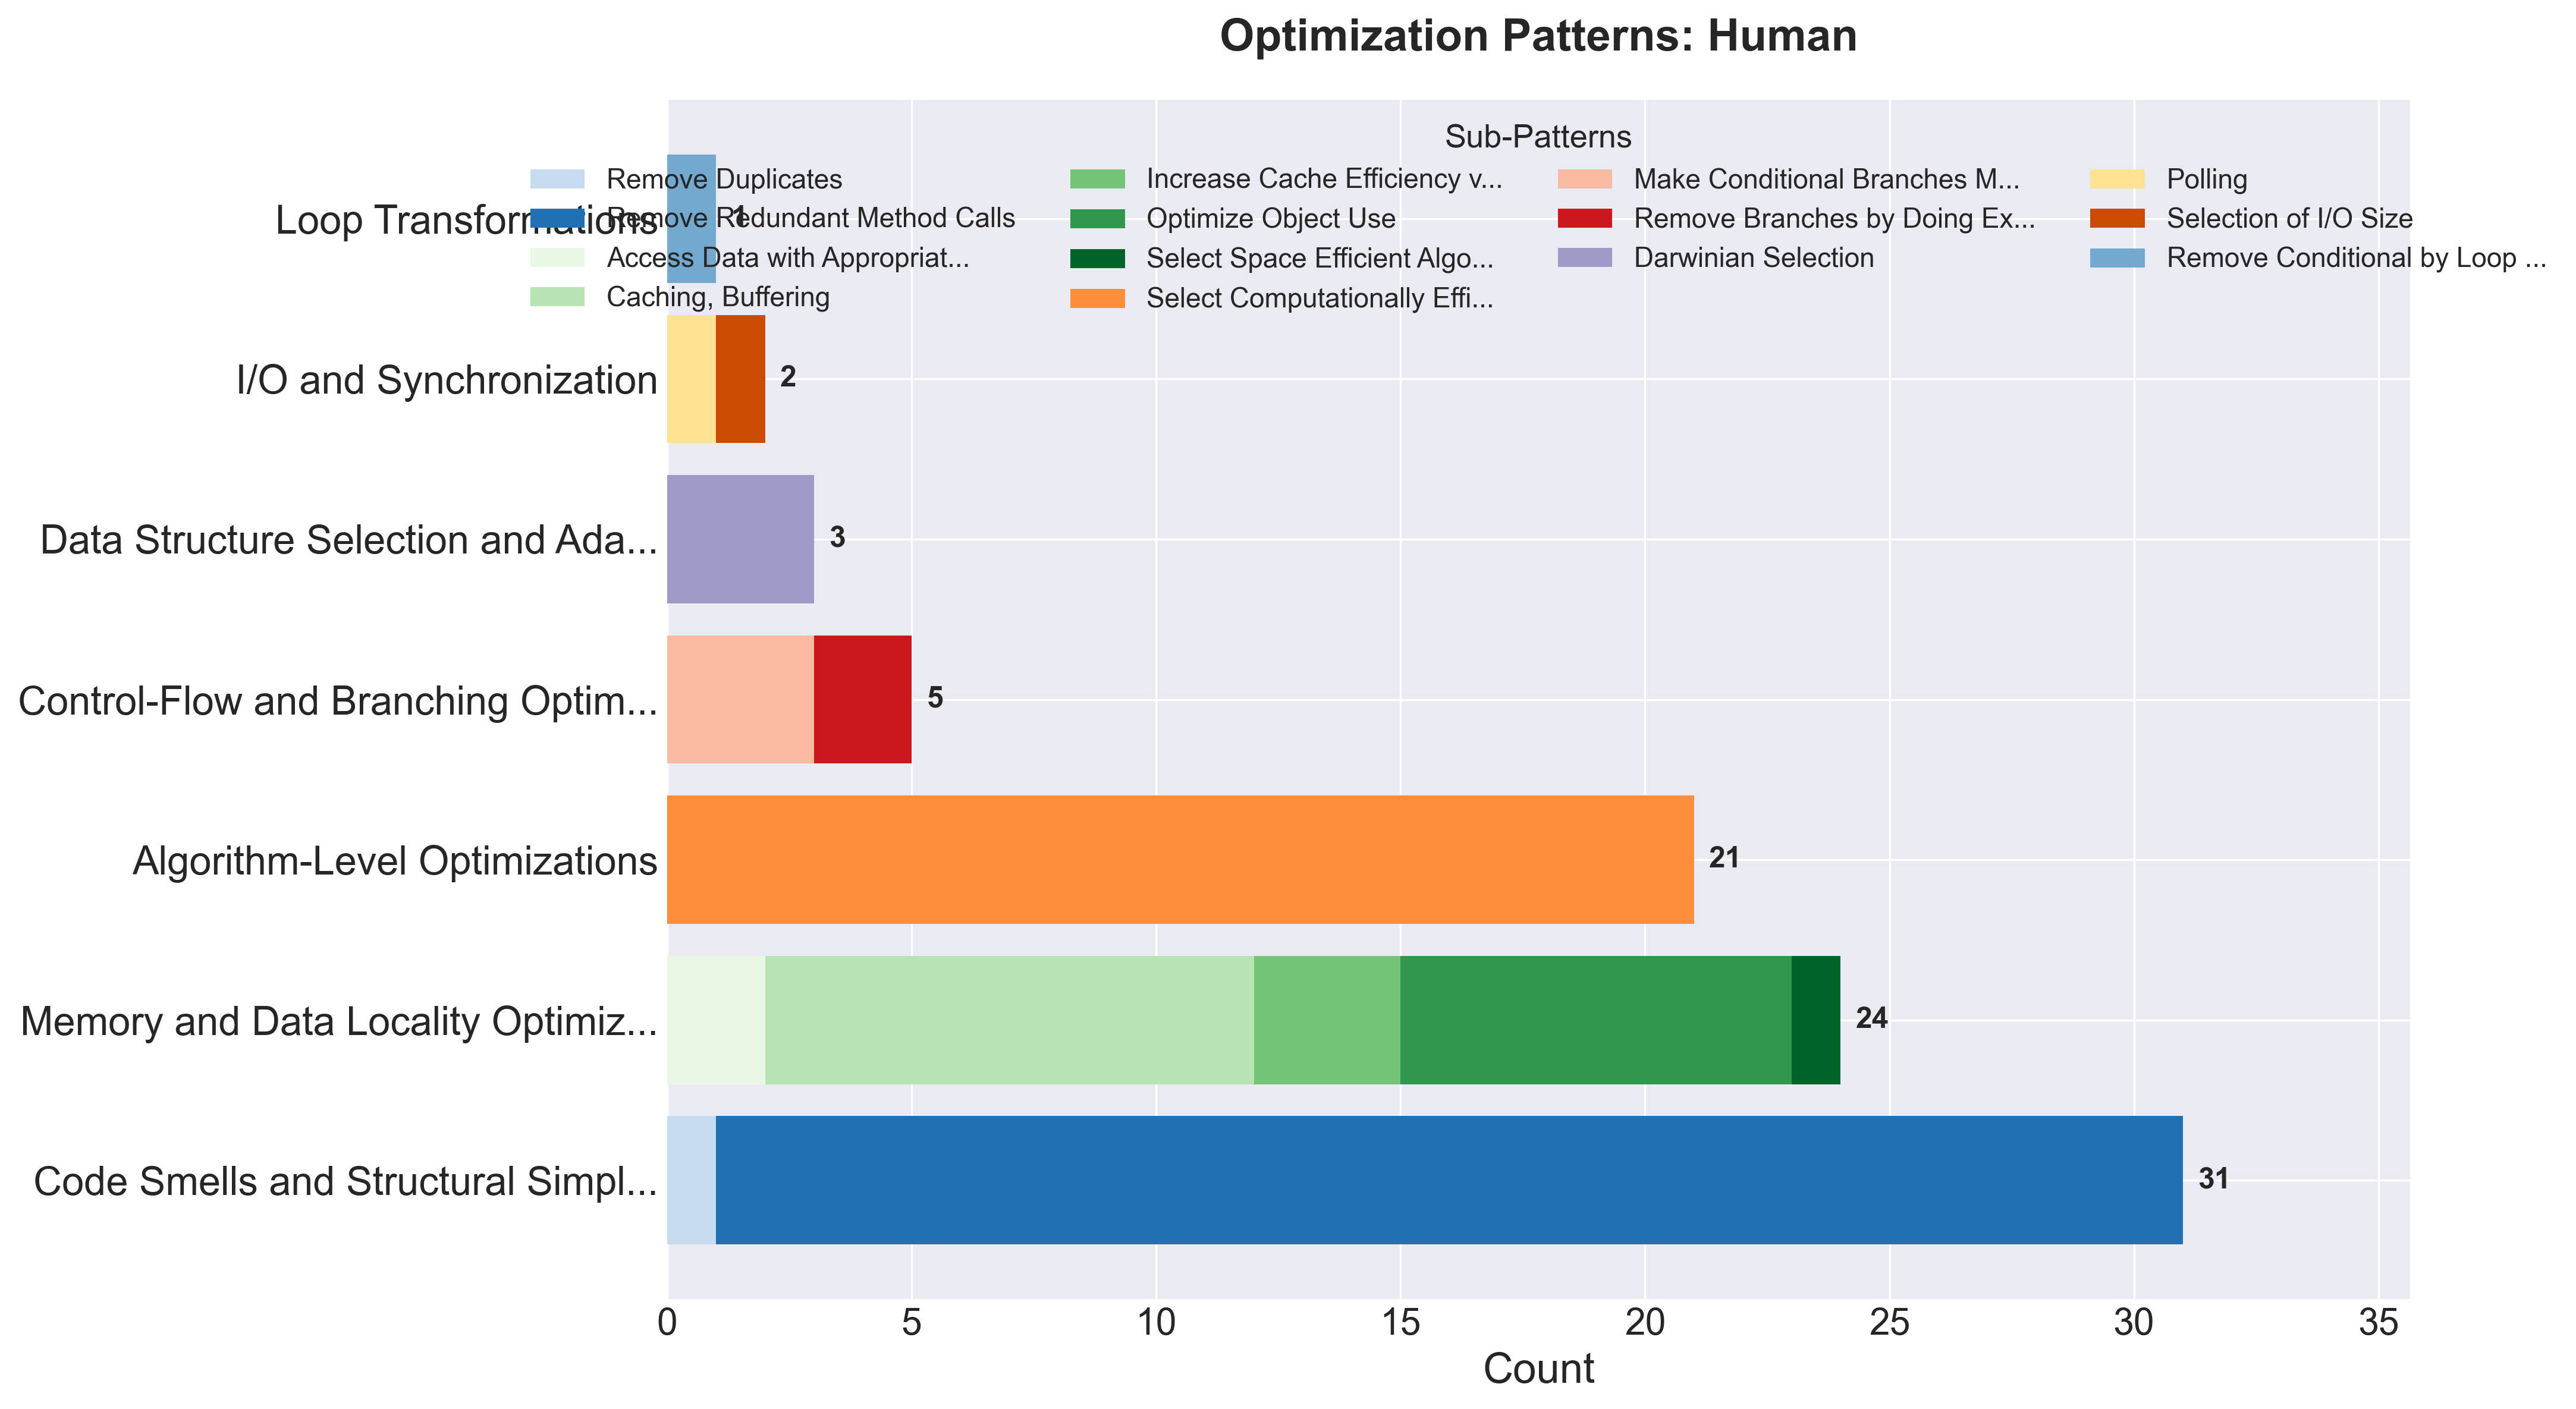

✓ Saved: results/pattern/agent_human/optimization_pattern_human.png

3. Creating pattern distribution heatmap...


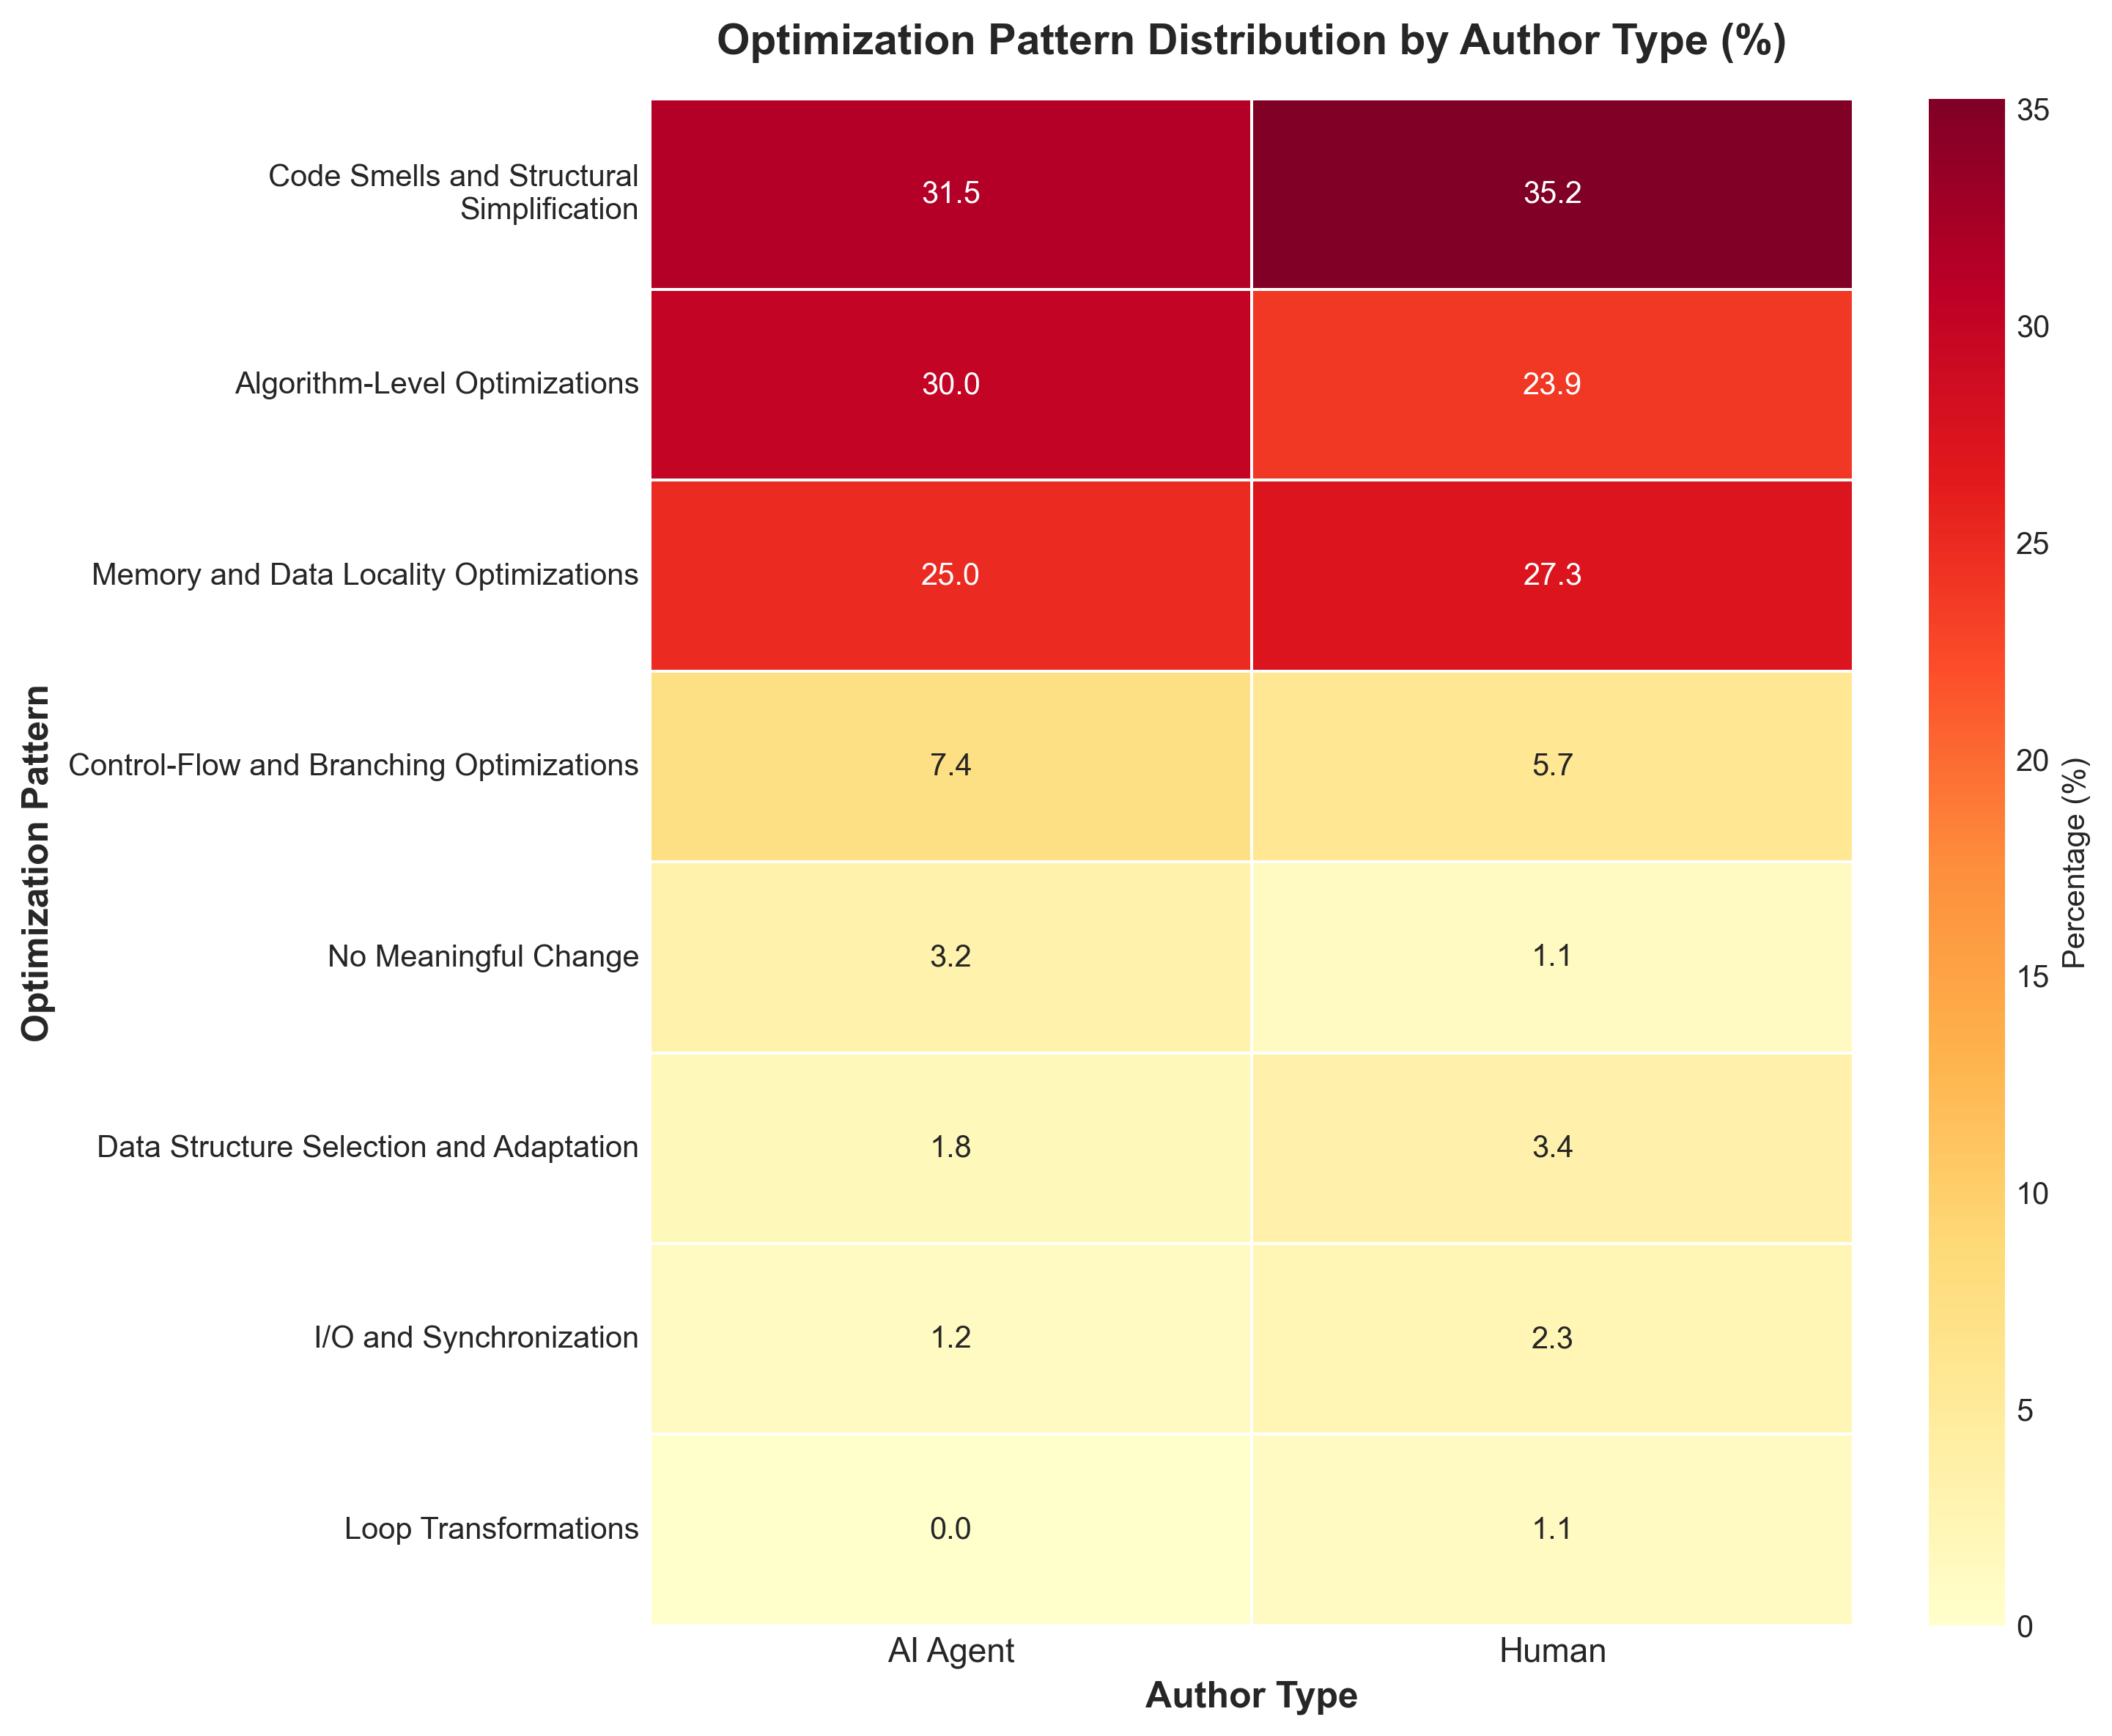

✓ Saved: pattern_heatmap_by_author.png

4. Creating statistical comparison table...


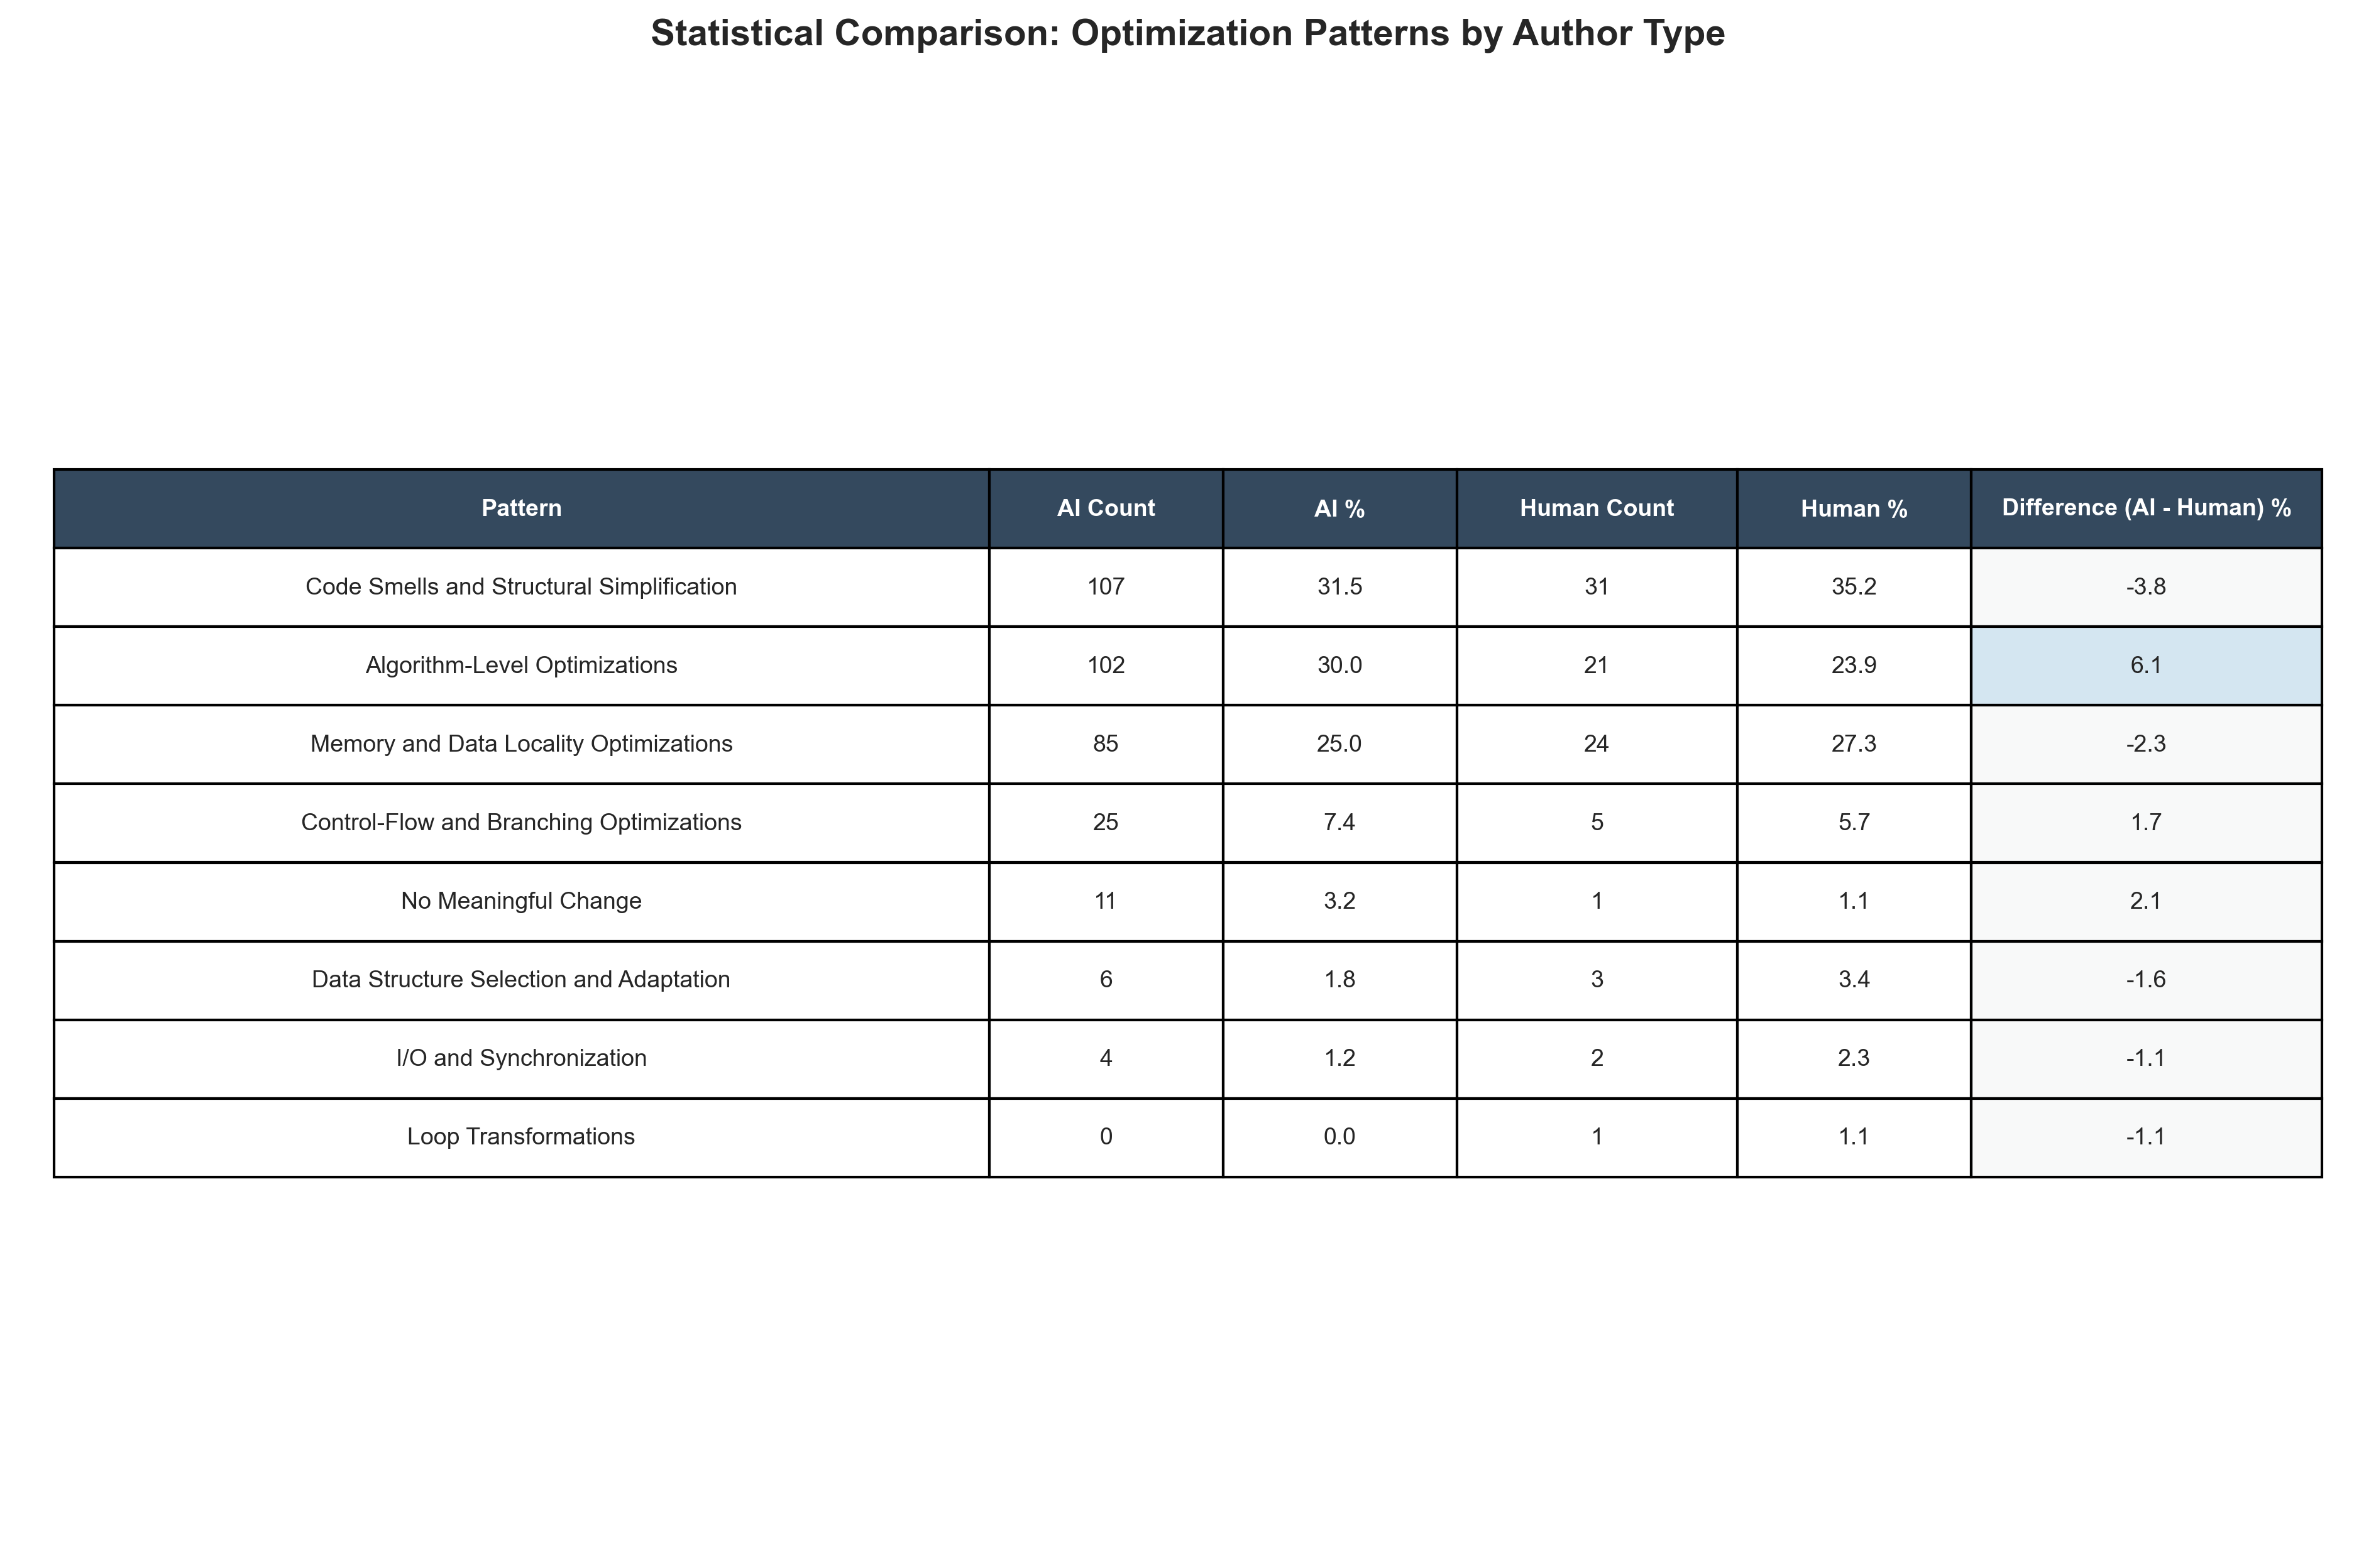

✓ Saved: statistical_comparison_table.png
✓ Saved: pattern_comparison_statistics.csv

✓ ALL VISUALIZATIONS COMPLETE!

Generated files:
  1. optimization_pattern_ai_agent.png - Stacked pattern/sub-pattern for AI
  2. optimization_pattern_human.png - Stacked pattern/sub-pattern for Human
  3. pattern_heatmap_by_author.png - Pattern distribution heatmap
  4. statistical_comparison_table.png - Detailed comparison table
  5. pattern_comparison_statistics.csv - Data in CSV format

PATTERN DISTRIBUTION HEATMAP
author_type                                AI Agent  Human
optimization_pattern                                      
Code Smells and Structural Simplification     31.50  35.20
Algorithm-Level Optimizations                 30.00  23.90
Memory and Data Locality Optimizations        25.00  27.30
Control-Flow and Branching Optimizations       7.40   5.70
No Meaningful Change                           3.20   1.10
Data Structure Selection and Adaptation        1.80   3.40
I/O and Synchroniza

In [48]:
# ============================================================================
# Visualization Script: Optimization Pattern Analysis (Revised)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import os

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

# Load data if exits
print("Loading data from csv files...")
if not (os.path.exists('datasets/ai_perf_prs_with_gpt_analysis.csv') and os.path.exists('datasets/human_perf_prs_with_gpt_analysis.csv')):
    raise FileNotFoundError("Required CSV files not found. Please run the analysis notebook first.")
ai_perf_prs_analyzed = pd.read_csv('datasets/ai_perf_prs_with_gpt_analysis.csv')
human_perf_prs_analyzed = pd.read_csv('datasets/human_perf_prs_with_gpt_analysis.csv')

# Combine datasets
analyzed = pd.concat([ai_perf_prs_analyzed, human_perf_prs_analyzed], ignore_index=True)
print(f"Combined dataset: {len(analyzed):,} performance PRs")
print(f"  AI Agents: {(analyzed['author_type'] == 'AI Agent').sum():,}")
print(f"  Humans: {(analyzed['author_type'] == 'Human').sum():,}")

# ============================================================================
# Helper Functions
# ============================================================================

def wrap_labels(labels, width=30):
    """Wrap long labels for better readability"""
    return [textwrap.fill(label, width) for label in labels]


# ============================================================================
# Pattern and Sub-Pattern Distribution (Single Figure per Author Type)
# Using the same style as the provided script
# ============================================================================

def plot_pattern_subpattern_stacked(analyzed, author_type):
    """
    Create stacked horizontal bar chart showing patterns and sub-patterns
    Similar style to the provided script
    """
    
    # Filter by author type
    subset = analyzed[analyzed['author_type'] == author_type].copy()
    
    # Get pattern and sub-pattern data
    pattern_subpattern = subset.groupby(['optimization_pattern', 'optimization_subpattern']).size()
    
    # Build data dictionary
    data = {}
    for (pattern, subpattern), count in pattern_subpattern.items():
        if pd.notna(pattern) and pd.notna(subpattern):
            if pattern not in data:
                data[pattern] = {}
            data[pattern][subpattern] = count
    
    if not data:
        print(f"No data available for {author_type}")
        return
    
    # Sort patterns by total count
    pattern_totals = {k: sum(v.values()) for k, v in data.items()}
    sorted_patterns = sorted(pattern_totals.keys(), key=lambda x: pattern_totals[x], reverse=True)
    data = {k: data[k] for k in sorted_patterns if k in data}
    
    # Short labels for patterns (y-axis)
    short_labels = {}
    for pattern in data.keys():
        # Truncate long pattern names
        if len(pattern) > 35:
            short_labels[pattern] = pattern[:32] + '...'
        else:
            short_labels[pattern] = pattern
    
    # Short labels for sub-patterns (legend)
    sub_short = {}
    for pattern, subs in data.items():
        for sub in subs.keys():
            if len(sub) > 30:
                sub_short[sub] = sub[:27] + '...'
            else:
                sub_short[sub] = sub
    
    # Color maps for each category (cycling through different colormaps)
    available_colormaps = ['Blues', 'Greens', 'Oranges', 'Reds', 'Purples', 'YlOrBr', 'PuBu', 'RdPu']
    colormaps = {}
    for idx, pattern in enumerate(data.keys()):
        num_subs = len(data[pattern])
        colormaps[pattern] = (available_colormaps[idx % len(available_colormaps)], num_subs)
    
    # Flatten subpatterns
    subpatterns = []
    for cat, sub in data.items():
        for sp in sub.keys():
            subpatterns.append((cat, sp))
    
    # Build DataFrame
    rows = []
    for cat in data.keys():
        row = [data[cat].get(sp, 0) for _, sp in subpatterns]
        rows.append(row)
    
    df = pd.DataFrame(rows,
                      index=list(data.keys()),
                      columns=[sp for _, sp in subpatterns])
    
    # Generate colors by category
    colors = []
    for cat, sp in subpatterns:
        cmap_name, count = colormaps[cat]
        cmap = plt.get_cmap(cmap_name)
        idx = list(data[cat].keys()).index(sp)
        colors.append(cmap((idx + 0.5) / max(count, 1)))
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, max(8, len(data) * 0.6)))
    left = np.zeros(len(df))
    y_labels = [short_labels[cat] for cat in df.index]
    
    for i, (_, sp) in enumerate(subpatterns):
        ax.barh(y_labels, df.iloc[:, i], left=left,
                label=sub_short[sp], color=colors[i])
        left += df.iloc[:, i].values
    
    # Add total counts
    totals = df.sum(axis=1).values
    for i, total in enumerate(totals):
        ax.text(total + max(totals)*0.01, i, str(int(total)), 
                va='center', fontsize=12, fontweight='bold')
    
    # Final styling
    ax.set_xlabel('Count', fontsize=17)
    ax.set_title(f'Optimization Patterns: {author_type}', fontsize=18, fontweight='bold', pad=20)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlim(0, max(totals) * 1.15)
    
    # Legend at top center
    ncol = min(4, (len(subpatterns) + 2) // 3)
    legend = ax.legend(title='Sub-Patterns',
                       loc='upper center',
                       bbox_to_anchor=(0.5, 1.0),
                       ncol=ncol,
                       framealpha=0.9,
                       fontsize=11,
                       title_fontsize=13)
    legend.get_frame().set_edgecolor('gray')
    legend.get_frame().set_linewidth(0.5)
    
    plt.tight_layout()
    
    # Save
    filename = f'results/pattern/agent_human/optimization_pattern_{author_type.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: {filename}")


# ============================================================================
# Pattern Distribution Heatmap by Author Type
# ============================================================================

def plot_pattern_heatmap(analyzed):
    """Create heatmap showing pattern frequency by author type (percentages)"""
    
    # Create pivot table with percentages
    pattern_pivot = pd.crosstab(
        analyzed['optimization_pattern'],
        analyzed['author_type'],
        normalize='columns'
    ) * 100
    
    # Sort by total frequency
    pattern_totals = analyzed['optimization_pattern'].value_counts()
    pattern_pivot = pattern_pivot.loc[pattern_totals.index]
    
    # Wrap labels
    wrapped_labels = wrap_labels(pattern_pivot.index, width=40)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, max(8, len(pattern_pivot) * 0.4)))
    
    # Create heatmap
    sns.heatmap(
        pattern_pivot,
        annot=True,
        fmt='.1f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Percentage (%)'},
        ax=ax,
        linewidths=0.5,
        linecolor='white'
    )
    
    ax.set_title('Optimization Pattern Distribution by Author Type (%)', 
                 fontweight='bold', fontsize=14, pad=15)
    ax.set_xlabel('Author Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Optimization Pattern', fontsize=12, fontweight='bold')
    ax.set_yticklabels(wrapped_labels, rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)
    
    plt.tight_layout()
    plt.savefig('results/pattern/agent_human/pattern_heatmap_by_author.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: pattern_heatmap_by_author.png")
    
    return pattern_pivot


# ============================================================================
# Statistical Comparison Table
# ============================================================================

def create_statistical_comparison_table(analyzed):
    """Create detailed statistical comparison table"""
    
    # Get all unique patterns
    all_patterns = analyzed['optimization_pattern'].value_counts().index
    
    comparison_data = []
    
    for pattern in all_patterns:
        ai_count = len(analyzed[(analyzed['author_type'] == 'AI Agent') & 
                                (analyzed['optimization_pattern'] == pattern)])
        human_count = len(analyzed[(analyzed['author_type'] == 'Human') & 
                                   (analyzed['optimization_pattern'] == pattern)])
        
        total_ai = len(analyzed[analyzed['author_type'] == 'AI Agent'])
        total_human = len(analyzed[analyzed['author_type'] == 'Human'])
        
        ai_pct = (ai_count / total_ai * 100) if total_ai > 0 else 0
        human_pct = (human_count / total_human * 100) if total_human > 0 else 0
        
        comparison_data.append({
            'Pattern': pattern,
            'AI Count': ai_count,
            'AI %': ai_pct,
            'Human Count': human_count,
            'Human %': human_pct,
            'Difference (AI - Human) %': ai_pct - human_pct
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('AI Count', ascending=False)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(16, max(10, len(comparison_df) * 0.5)))
    ax.axis('tight')
    ax.axis('off')
    
    # Wrap pattern names for table
    comparison_df_display = comparison_df.copy()
    comparison_df_display['Pattern'] = [textwrap.fill(p, width=50) for p in comparison_df_display['Pattern']]
    
    # Create table
    table_data = comparison_df_display.round(1).values
    table = ax.table(cellText=table_data,
                    colLabels=comparison_df_display.columns,
                    cellLoc='center',
                    loc='center',
                    colWidths=[0.4, 0.1, 0.1, 0.12, 0.1, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.5)
    
    # Color code the difference column
    for i in range(len(comparison_df)):
        cell = table[(i+1, 5)]  # Difference column (0-indexed in data, +1 for header)
        diff_val = comparison_df.iloc[i]['Difference (AI - Human) %']
        if diff_val > 5:
            cell.set_facecolor('#d4e6f1')  # Light blue for AI advantage
        elif diff_val < -5:
            cell.set_facecolor('#fadbd8')  # Light red for Human advantage
        else:
            cell.set_facecolor('#f8f9f9')  # Gray for similar
    
    # Header styling
    for j in range(len(comparison_df_display.columns)):
        cell = table[(0, j)]
        cell.set_facecolor('#34495e')
        cell.set_text_props(weight='bold', color='white')
    
    plt.title('Statistical Comparison: Optimization Patterns by Author Type', 
             fontsize=14, fontweight='bold', pad=20)
    
    plt.savefig('results/pattern/agent_human/statistical_comparison_table.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: statistical_comparison_table.png")
    
    # Also save as CSV
    comparison_df.to_csv('results/pattern/agent_human/pattern_comparison_statistics.csv', index=False)
    print("✓ Saved: pattern_comparison_statistics.csv")
    
    return comparison_df


# ============================================================================
# Summary Statistics
# ============================================================================

def print_summary_statistics(analyzed):
    """Print summary statistics"""
    
    print("\n" + "="*80)
    print("OPTIMIZATION PATTERN ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"\nTotal PRs Analyzed: {len(analyzed):,}")
    print(f"  AI Agents: {(analyzed['author_type'] == 'AI Agent').sum():,}")
    print(f"  Humans: {(analyzed['author_type'] == 'Human').sum():,}")
    
    print(f"\nUnique Patterns: {analyzed['optimization_pattern'].nunique()}")
    print(f"Unique Sub-Patterns: {analyzed['optimization_subpattern'].nunique()}")
    
    print("\n" + "-"*80)
    print("TOP 5 PATTERNS (OVERALL)")
    print("-"*80)
    top_patterns = analyzed['optimization_pattern'].value_counts().head(5)
    for pattern, count in top_patterns.items():
        pct = count / len(analyzed) * 100
        print(f"  {pattern[:60]:60s} {count:4d} ({pct:5.1f}%)")
    
    print("\n" + "-"*80)
    print("TOP 5 PATTERNS (AI AGENTS)")
    print("-"*80)
    ai_subset = analyzed[analyzed['author_type'] == 'AI Agent']
    top_ai = ai_subset['optimization_pattern'].value_counts().head(5)
    for pattern, count in top_ai.items():
        pct = count / len(ai_subset) * 100
        print(f"  {pattern[:60]:60s} {count:4d} ({pct:5.1f}%)")
    
    print("\n" + "-"*80)
    print("TOP 5 PATTERNS (HUMANS)")
    print("-"*80)
    human_subset = analyzed[analyzed['author_type'] == 'Human']
    top_human = human_subset['optimization_pattern'].value_counts().head(5)
    for pattern, count in top_human.items():
        pct = count / len(human_subset) * 100
        print(f"  {pattern[:60]:60s} {count:4d} ({pct:5.1f}%)")
    
    print("\n" + "="*80)


# ============================================================================
# Main Execution
# ============================================================================

def generate_all_visualizations():
    """Generate all requested visualizations"""
    
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    
    # Print summary statistics
    print_summary_statistics(analyzed)
    
    print("\n1. Creating pattern-subpattern distribution for AI Agents...")
    plot_pattern_subpattern_stacked(analyzed, 'AI Agent')
    
    print("\n2. Creating pattern-subpattern distribution for Humans...")
    plot_pattern_subpattern_stacked(analyzed, 'Human')
    
    print("\n3. Creating pattern distribution heatmap...")
    pattern_pivot = plot_pattern_heatmap(analyzed)
    
    print("\n4. Creating statistical comparison table...")
    comparison_df = create_statistical_comparison_table(analyzed)
    
    print("\n" + "="*80)
    print("✓ ALL VISUALIZATIONS COMPLETE!")
    print("="*80)
    print("\nGenerated files:")
    print("  1. optimization_pattern_ai_agent.png - Stacked pattern/sub-pattern for AI")
    print("  2. optimization_pattern_human.png - Stacked pattern/sub-pattern for Human")
    print("  3. pattern_heatmap_by_author.png - Pattern distribution heatmap")
    print("  4. statistical_comparison_table.png - Detailed comparison table")
    print("  5. pattern_comparison_statistics.csv - Data in CSV format")
    
    return {
        'pattern_pivot': pattern_pivot,
        'comparison_df': comparison_df
    }


# Run all visualizations
results = generate_all_visualizations()

# Display comparison summary
print("\n" + "="*80)
print("PATTERN DISTRIBUTION HEATMAP")
print("="*80)
print(results['pattern_pivot'].round(1))

print("\n" + "="*80)
print("STATISTICAL COMPARISON (Top 10)")
print("="*80)
print(results['comparison_df'].head(10).to_string(index=False))

## Optimization Pattern Analysis: between 5 AI Agents

Loading data from csv files...
AI Agent dataset: 340 performance PRs

Agent distribution:
  Claude_Code: 3
  Copilot: 44
  OpenAI_Codex: 207
  Cursor: 24
  Devin: 62

GENERATING AI AGENT COMPARISON VISUALIZATIONS

AI AGENTS OPTIMIZATION PATTERN ANALYSIS SUMMARY

Total AI Agent PRs Analyzed: 340
  Claude_Code: 3 (0.9%)
  Copilot: 44 (12.9%)
  Cursor: 24 (7.1%)
  Devin: 62 (18.2%)
  OpenAI_Codex: 207 (60.9%)

Unique Patterns: 7
Unique Sub-Patterns: 19

--------------------------------------------------------------------------------
TOP 5 PATTERNS (OVERALL)
--------------------------------------------------------------------------------
  Code Smells and Structural Simplification                     107 ( 31.5%)
  Algorithm-Level Optimizations                                 102 ( 30.0%)
  Memory and Data Locality Optimizations                         85 ( 25.0%)
  Control-Flow and Branching Optimizations                       25 (  7.4%)
  No Meaningful Change                            

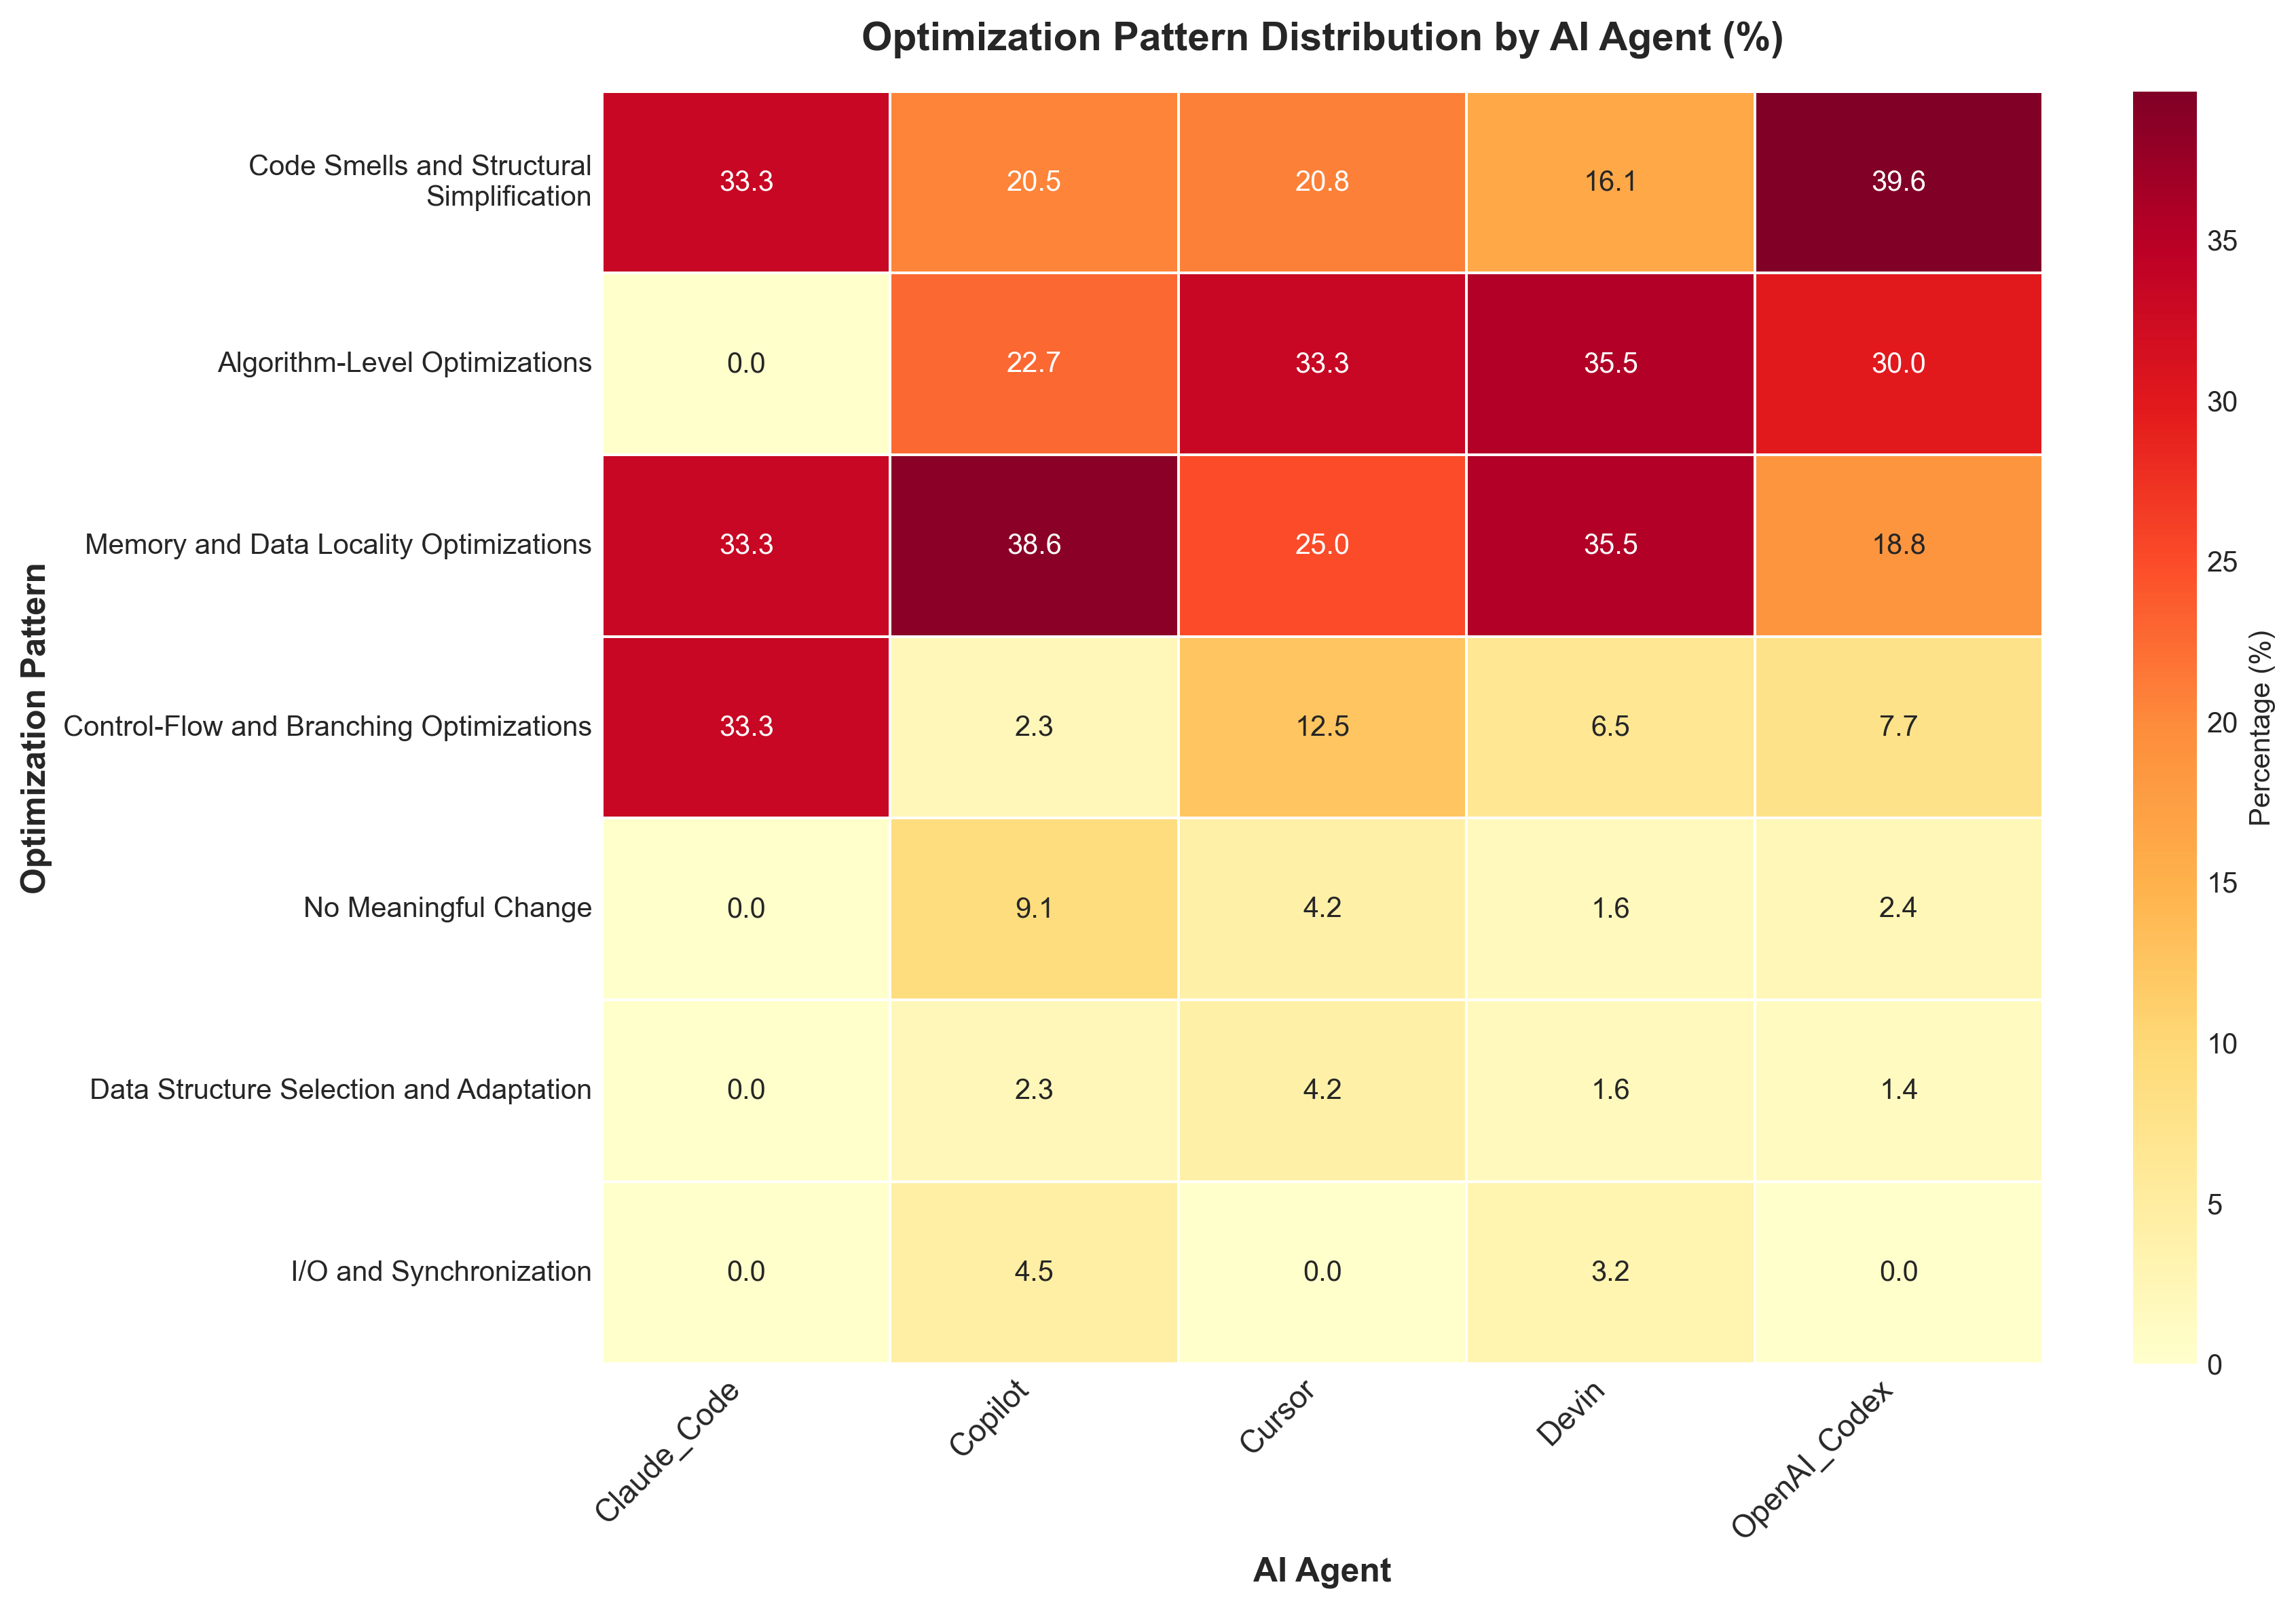

✓ Saved: pattern_heatmap_by_agent.png

2. Creating statistical comparison table...


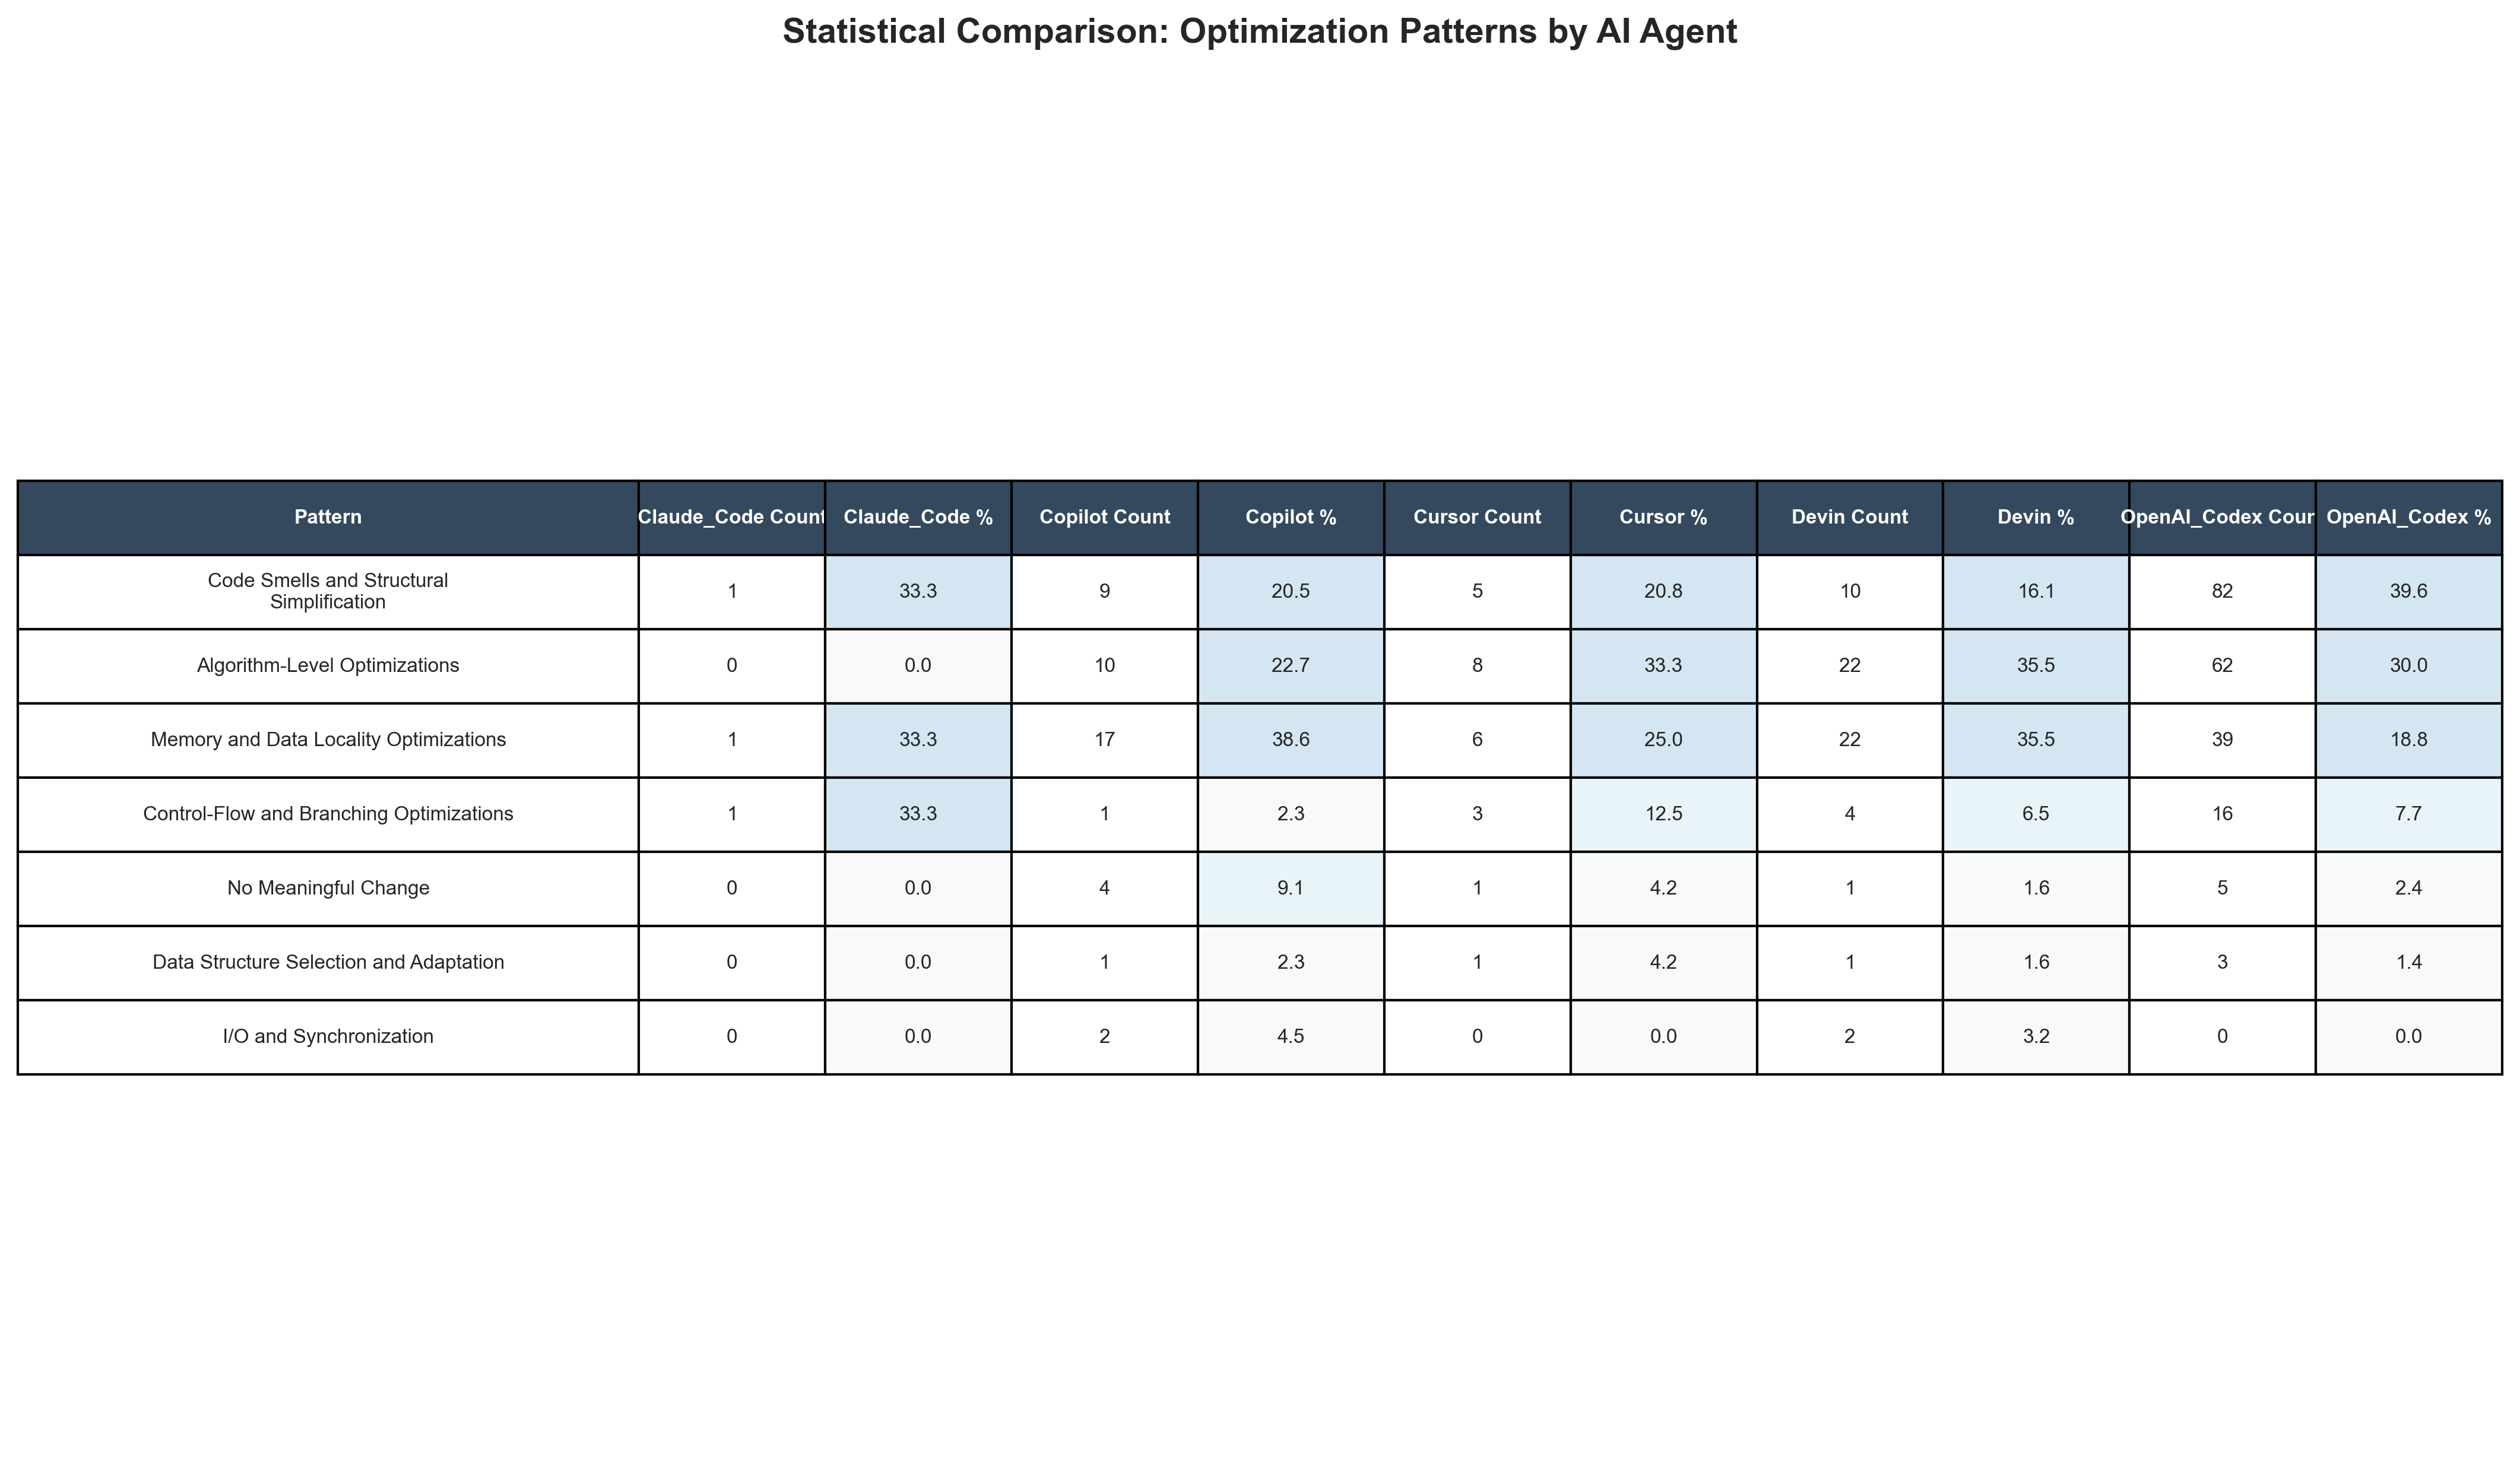

✓ Saved: statistical_comparison_table_agents.png
✓ Saved: pattern_comparison_statistics_agents.csv

✓ ALL VISUALIZATIONS COMPLETE!

Generated files:
  1. pattern_heatmap_by_agent.png - Pattern distribution heatmap
  2. statistical_comparison_table_agents.png - Detailed comparison table
  3. pattern_comparison_statistics_agents.csv - Data in CSV format

PATTERN DISTRIBUTION HEATMAP (ALL AGENTS)
agent                                      Claude_Code  Copilot  Cursor  \
optimization_pattern                                                      
Code Smells and Structural Simplification        33.30    20.50   20.80   
Algorithm-Level Optimizations                     0.00    22.70   33.30   
Memory and Data Locality Optimizations           33.30    38.60   25.00   
Control-Flow and Branching Optimizations         33.30     2.30   12.50   
No Meaningful Change                              0.00     9.10    4.20   
Data Structure Selection and Adaptation           0.00     2.30    4.20   
I/O

In [49]:
# ============================================================================
# Visualization Script: AI Agents Comparison - Optimization Pattern Analysis
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import os

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

# Load data if exists
print("Loading data from csv files...")
if not os.path.exists('datasets/ai_perf_prs_with_gpt_analysis.csv'):
    raise FileNotFoundError("Required CSV file 'datasets/ai_perf_prs_with_gpt_analysis.csv' not found. Please run the analysis notebook first.")

ai_perf_prs_analyzed = pd.read_csv('datasets/ai_perf_prs_with_gpt_analysis.csv')

# Filter only AI agents
ai_agents = ai_perf_prs_analyzed[ai_perf_prs_analyzed['author_type'] == 'AI Agent'].copy()

# Check for agent column
if 'agent' not in ai_agents.columns:
    raise ValueError("'agent' column not found in the dataset. Please ensure the data includes agent information.")

print(f"AI Agent dataset: {len(ai_agents):,} performance PRs")
print(f"\nAgent distribution:")
for agent in ai_agents['agent'].unique():
    count = (ai_agents['agent'] == agent).sum()
    print(f"  {agent}: {count:,}")

# ============================================================================
# Helper Functions
# ============================================================================

def wrap_labels(labels, width=30):
    """Wrap long labels for better readability"""
    return [textwrap.fill(label, width) for label in labels]


# ============================================================================
# Pattern Distribution Heatmap by AI Agent
# ============================================================================

def plot_pattern_heatmap(analyzed):
    """Create heatmap showing pattern frequency by AI agent (percentages)"""
    
    # Create pivot table with percentages
    pattern_pivot = pd.crosstab(
        analyzed['optimization_pattern'],
        analyzed['agent'],
        normalize='columns'
    ) * 100
    
    # Sort by total frequency across all agents
    pattern_totals = analyzed['optimization_pattern'].value_counts()
    pattern_pivot = pattern_pivot.loc[pattern_totals.index]
    
    # Wrap labels
    wrapped_labels = wrap_labels(pattern_pivot.index, width=40)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, max(8, len(pattern_pivot) * 0.4)))
    
    # Create heatmap
    sns.heatmap(
        pattern_pivot,
        annot=True,
        fmt='.1f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Percentage (%)'},
        ax=ax,
        linewidths=0.5,
        linecolor='white'
    )
    
    ax.set_title('Optimization Pattern Distribution by AI Agent (%)', 
                 fontweight='bold', fontsize=14, pad=15)
    ax.set_xlabel('AI Agent', fontsize=12, fontweight='bold')
    ax.set_ylabel('Optimization Pattern', fontsize=12, fontweight='bold')
    ax.set_yticklabels(wrapped_labels, rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=11, ha='right')
    
    plt.tight_layout()
    plt.savefig('results/pattern/between_agents/pattern_heatmap_by_agent.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: pattern_heatmap_by_agent.png")
    
    return pattern_pivot


# ============================================================================
# Statistical Comparison Table
# ============================================================================

def create_statistical_comparison_table(analyzed):
    """Create detailed statistical comparison table for all AI agents"""
    
    # Get all unique patterns
    all_patterns = analyzed['optimization_pattern'].value_counts().index
    agents = sorted(analyzed['agent'].unique())
    
    comparison_data = []
    
    for pattern in all_patterns:
        row_data = {'Pattern': pattern}
        
        for agent in agents:
            count = len(analyzed[(analyzed['agent'] == agent) & 
                                (analyzed['optimization_pattern'] == pattern)])
            total_agent = len(analyzed[analyzed['agent'] == agent])
            pct = (count / total_agent * 100) if total_agent > 0 else 0
            
            row_data[f'{agent} Count'] = count
            row_data[f'{agent} %'] = pct
        
        comparison_data.append(row_data)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Sort by most common pattern overall
    pattern_totals = []
    for idx, row in comparison_df.iterrows():
        total = sum([row[f'{agent} Count'] for agent in agents])
        pattern_totals.append(total)
    comparison_df['Total'] = pattern_totals
    comparison_df = comparison_df.sort_values('Total', ascending=False).drop('Total', axis=1)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(18, max(10, len(comparison_df) * 0.5)))
    ax.axis('tight')
    ax.axis('off')
    
    # Wrap pattern names for table
    comparison_df_display = comparison_df.copy()
    comparison_df_display['Pattern'] = [textwrap.fill(p, width=40) for p in comparison_df_display['Pattern']]
    
    # Create table
    table_data = comparison_df_display.round(1).values
    table = ax.table(cellText=table_data,
                    colLabels=comparison_df_display.columns,
                    cellLoc='center',
                    loc='center',
                    colWidths=[0.25] + [0.075] * (len(agents) * 2))
    
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 2.5)
    
    # Color code cells by value
    for i in range(len(comparison_df)):
        for j in range(1, len(comparison_df_display.columns)):
            cell = table[(i+1, j)]
            # Get percentage columns
            if '% ' in comparison_df_display.columns[j] or comparison_df_display.columns[j].endswith('%'):
                val = comparison_df.iloc[i, j]
                if val > 15:
                    cell.set_facecolor('#d4e6f1')  # Light blue for high
                elif val > 5:
                    cell.set_facecolor('#e8f4f8')  # Very light blue for medium
                else:
                    cell.set_facecolor('#f8f9f9')  # Gray for low
    
    # Header styling
    for j in range(len(comparison_df_display.columns)):
        cell = table[(0, j)]
        cell.set_facecolor('#34495e')
        cell.set_text_props(weight='bold', color='white')
    
    plt.title('Statistical Comparison: Optimization Patterns by AI Agent', 
             fontsize=14, fontweight='bold', pad=20)
    
    plt.savefig('results/pattern/between_agents/statistical_comparison_table_agents.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: statistical_comparison_table_agents.png")
    
    # Also save as CSV
    comparison_df.to_csv('results/pattern/between_agents/pattern_comparison_statistics_agents.csv', index=False)
    print("✓ Saved: pattern_comparison_statistics_agents.csv")
    
    return comparison_df


# ============================================================================
# Summary Statistics
# ============================================================================

def print_summary_statistics(analyzed):
    """Print summary statistics"""
    
    print("\n" + "="*80)
    print("AI AGENTS OPTIMIZATION PATTERN ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"\nTotal AI Agent PRs Analyzed: {len(analyzed):,}")
    
    agents = sorted(analyzed['agent'].unique())
    for agent in agents:
        count = (analyzed['agent'] == agent).sum()
        pct = count / len(analyzed) * 100
        print(f"  {agent}: {count:,} ({pct:.1f}%)")
    
    print(f"\nUnique Patterns: {analyzed['optimization_pattern'].nunique()}")
    print(f"Unique Sub-Patterns: {analyzed['optimization_subpattern'].nunique()}")
    
    print("\n" + "-"*80)
    print("TOP 5 PATTERNS (OVERALL)")
    print("-"*80)
    top_patterns = analyzed['optimization_pattern'].value_counts().head(5)
    for pattern, count in top_patterns.items():
        pct = count / len(analyzed) * 100
        print(f"  {pattern[:60]:60s} {count:4d} ({pct:5.1f}%)")
    
    # Print top 5 for each agent
    for agent in agents:
        print("\n" + "-"*80)
        print(f"TOP 5 PATTERNS ({agent.upper()})")
        print("-"*80)
        agent_subset = analyzed[analyzed['agent'] == agent]
        if len(agent_subset) > 0:
            top_agent = agent_subset['optimization_pattern'].value_counts().head(5)
            for pattern, count in top_agent.items():
                pct = count / len(agent_subset) * 100
                print(f"  {pattern[:60]:60s} {count:4d} ({pct:5.1f}%)")
        else:
            print(f"  No data available")
    
    print("\n" + "="*80)


# ============================================================================
# Main Execution
# ============================================================================

def generate_all_visualizations():
    """Generate all requested visualizations"""
    
    print("\n" + "="*80)
    print("GENERATING AI AGENT COMPARISON VISUALIZATIONS")
    print("="*80)
    
    # Print summary statistics
    print_summary_statistics(ai_agents)
    
    print("\n1. Creating pattern distribution heatmap...")
    pattern_pivot = plot_pattern_heatmap(ai_agents)
    
    print("\n2. Creating statistical comparison table...")
    comparison_df = create_statistical_comparison_table(ai_agents)
    
    print("\n" + "="*80)
    print("✓ ALL VISUALIZATIONS COMPLETE!")
    print("="*80)
    print("\nGenerated files:")
    print("  1. pattern_heatmap_by_agent.png - Pattern distribution heatmap")
    print("  2. statistical_comparison_table_agents.png - Detailed comparison table")
    print("  3. pattern_comparison_statistics_agents.csv - Data in CSV format")
    
    return {
        'pattern_pivot': pattern_pivot,
        'comparison_df': comparison_df
    }


# Run all visualizations
results = generate_all_visualizations()

# Display comparison summary
print("\n" + "="*80)
print("PATTERN DISTRIBUTION HEATMAP (ALL AGENTS)")
print("="*80)
print(results['pattern_pivot'].round(1))

print("\n" + "="*80)
print("STATISTICAL COMPARISON (Top 10)")
print("="*80)
print(results['comparison_df'].head(10).to_string(index=False))

In [57]:
# ============================================================================
# Load and Merge GPT Analysis Data
# ============================================================================

# Load analyzed performance PRs with GPT patterns
print("Loading GPT-analyzed performance PRs...")
ai_perf_prs_analyzed = pd.read_csv('datasets/ai_perf_prs_with_gpt_analysis.csv')
human_perf_prs_analyzed = pd.read_csv('datasets/human_perf_prs_with_gpt_analysis.csv')

# Combine AI and Human analyzed datasets
perf_prs_analyzed = pd.concat([ai_perf_prs_analyzed, human_perf_prs_analyzed], ignore_index=True)
print(f"  Combined: {len(perf_prs_analyzed):,} analyzed PRs")

# Define GPT analysis columns to merge
gpt_analysis_cols = [
    'id',
    'gpt_success',
    'gpt_explanation',
    'gpt_comparison',
    'optimization_pattern',
    'optimization_subpattern'
]

# Select available columns
available_gpt_cols = [col for col in gpt_analysis_cols if col in perf_prs_analyzed.columns]

# Drop existing GPT columns from perf_prs to avoid conflicts
existing_gpt_cols = [col for col in available_gpt_cols if col in perf_prs.columns and col != 'id']
if existing_gpt_cols:
    print(f"  Dropping existing GPT columns: {existing_gpt_cols}")
    perf_prs = perf_prs.drop(columns=existing_gpt_cols)

# Merge GPT analysis back into main perf_prs dataframe
print("Merging GPT analysis into perf_prs...")
perf_prs = perf_prs.merge(
    perf_prs_analyzed[available_gpt_cols],
    on='id',
    how='left'
)

print(f"✓ Merge complete")
print(f"  Total PRs: {len(perf_prs):,}")
print(f"  With GPT success: {perf_prs['gpt_success'].sum():,}")
print(f"  With patterns: {perf_prs['optimization_pattern'].notna().sum():,}")

Loading GPT-analyzed performance PRs...
  Combined: 428 analyzed PRs
  Dropping existing GPT columns: ['gpt_explanation', 'gpt_comparison', 'optimization_pattern', 'optimization_subpattern']
Merging GPT analysis into perf_prs...
✓ Merge complete
  Total PRs: 428
  With GPT success: 428
  With patterns: 428


## Testing and Evaluation Behavior [TODO]

## Description Quality [Needs to double check and find a better way to do it]

In [58]:
def assess_description_quality(row):
    """Score description quality (0-5)"""
    body = str(row['body']).lower()
    
    if pd.isna(row['body']) or body == 'nan' or len(body.strip()) < 50:
        return 0
    
    score = 0
    
    # Problem statement
    if any(word in body for word in ['problem', 'issue', 'slow', 'bottleneck', 'inefficient']):
        score += 1
    
    # Solution description
    if any(word in body for word in ['solution', 'implement', 'change', 'optimize', 'improve']):
        score += 1
    
    # Measurements
    if any(word in body for word in ['benchmark', 'test', 'measure', 'result']):
        score += 1
    
    # Before/after comparison
    if any(word in body for word in ['before', 'after', 'was', 'now', 'reduced', 'improved']):
        score += 1
    
    return score

perf_prs['description_quality_score'] = perf_prs.apply(assess_description_quality, axis=1)

print("✓ Description quality scored")
print(f"  Avg quality score: {perf_prs['description_quality_score'].mean():.2f}/4")

✓ Description quality scored
  Avg quality score: 2.06/4


## Overview: AI Agents vs Humans

In [62]:
# High-level comparison 
comparison_stats = perf_prs.groupby('author_type').agg({
    'id': 'count',
    'is_merged': ['sum', 'mean'],
    'time_to_merge_hours': ['mean', 'median'],
    'has_body': 'mean',
    'body_length': 'mean',
    'description_quality_score': 'mean',
    'optimization_pattern': 'nunique',  # Number of unique patterns used
    'primary_language': 'nunique'
}).round(2)

comparison_stats.columns = [
    'Total PRs', 'Merged PRs', 'Merge Rate', 'Avg Time to Merge (hrs)', 
    'Median Time to Merge (hrs)', 'Body Rate', 'Avg Body Length',
    'Avg Quality Score', 'Unique Patterns', 'Unique Languages'
]

comparison_stats['Merge Rate (%)'] = (comparison_stats['Merge Rate'] * 100).round(1)
comparison_stats['Body Rate (%)'] = (comparison_stats['Body Rate'] * 100).round(1)

print("="*100)
print("PERFORMANCE PR COMPARISON: AI AGENTS VS HUMANS")
print("="*100)
print(comparison_stats[[
    'Total PRs', 'Merge Rate (%)', 'Median Time to Merge (hrs)',
    'Body Rate (%)', 'Avg Body Length', 'Avg Quality Score',
    'Unique Patterns', 'Unique Languages'
]])

# Statistical test for merge rate difference
ai_merged = perf_prs[perf_prs['author_type'] == 'AI Agent']['is_merged']
human_merged = perf_prs[perf_prs['author_type'] == 'Human']['is_merged']

chi2, p_value = stats.chi2_contingency(
    pd.crosstab(perf_prs['author_type'], perf_prs['is_merged'])
)[:2]

print(f"\n📊 Statistical Test (Merge Rate Difference):")
print(f"  Chi-square: {chi2:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Significant: {'✓ Yes' if p_value < 0.05 else '✗ No'} (α=0.05)")

diff = comparison_stats.loc['AI Agent', 'Merge Rate (%)'] - comparison_stats.loc['Human', 'Merge Rate (%)']
print(f"  Effect: AI agents {'+' if diff > 0 else ''}{diff:.1f}% merge rate vs humans")

# Additional pattern-based insights
print(f"\n🎯 Optimization Pattern Insights:")

# Filter successful GPT analyses
analyzed = perf_prs[perf_prs['gpt_success'] == True].copy()

if len(analyzed) > 0:
    # Most common patterns by author type
    print(f"\nTop 3 Patterns by Author Type:")
    for author_type in ['AI Agent', 'Human']:
        subset = analyzed[analyzed['author_type'] == author_type]
        if len(subset) > 0:
            top_patterns = subset['optimization_pattern'].value_counts().head(3)
            print(f"\n  {author_type}:")
            for pattern, count in top_patterns.items():
                pct = count / len(subset) * 100
                # Truncate long pattern names
                pattern_short = pattern[:50] + '...' if len(pattern) > 50 else pattern
                print(f"    {pattern_short:52s} {count:3d} ({pct:5.1f}%)")
    
    # Pattern diversity comparison
    ai_pattern_diversity = analyzed[analyzed['author_type'] == 'AI Agent']['optimization_pattern'].nunique()
    human_pattern_diversity = analyzed[analyzed['author_type'] == 'Human']['optimization_pattern'].nunique()
    
    print(f"\nPattern Diversity:")
    print(f"  AI Agents use {ai_pattern_diversity} unique patterns")
    print(f"  Humans use {human_pattern_diversity} unique patterns")
    
    # Success rate by pattern (top 5)
    print(f"\nMerge Rate by Top 5 Optimization Patterns:")
    top_5_patterns = analyzed['optimization_pattern'].value_counts().head(5).index
    
    for pattern in top_5_patterns:
        pattern_prs = analyzed[analyzed['optimization_pattern'] == pattern]
        if len(pattern_prs) > 0:
            merge_rate = pattern_prs['is_merged'].mean() * 100
            pattern_short = pattern[:45] + '...' if len(pattern) > 45 else pattern
            print(f"  {pattern_short:47s} {merge_rate:5.1f}% ({len(pattern_prs):3d} PRs)")

else:
    print("\n⚠ No successful GPT analyses available for pattern insights")

print("\n" + "="*100)

PERFORMANCE PR COMPARISON: AI AGENTS VS HUMANS
             Total PRs  Merge Rate (%)  Median Time to Merge (hrs)  \
author_type                                                          
AI Agent           340           55.00                        0.03   
Human               88           65.00                        2.27   

             Body Rate (%)  Avg Body Length  Avg Quality Score  \
author_type                                                      
AI Agent             99.00          1156.68               2.15   
Human                84.00          2070.76               1.70   

             Unique Patterns  Unique Languages  
author_type                                     
AI Agent                   7                23  
Human                      8                16  

📊 Statistical Test (Merge Rate Difference):
  Chi-square: 2.1935
  P-value: 0.138597
  Significant: ✗ No (α=0.05)
  Effect: AI agents -10.0% merge rate vs humans

🎯 Optimization Pattern Insights:

Top 3 Pattern

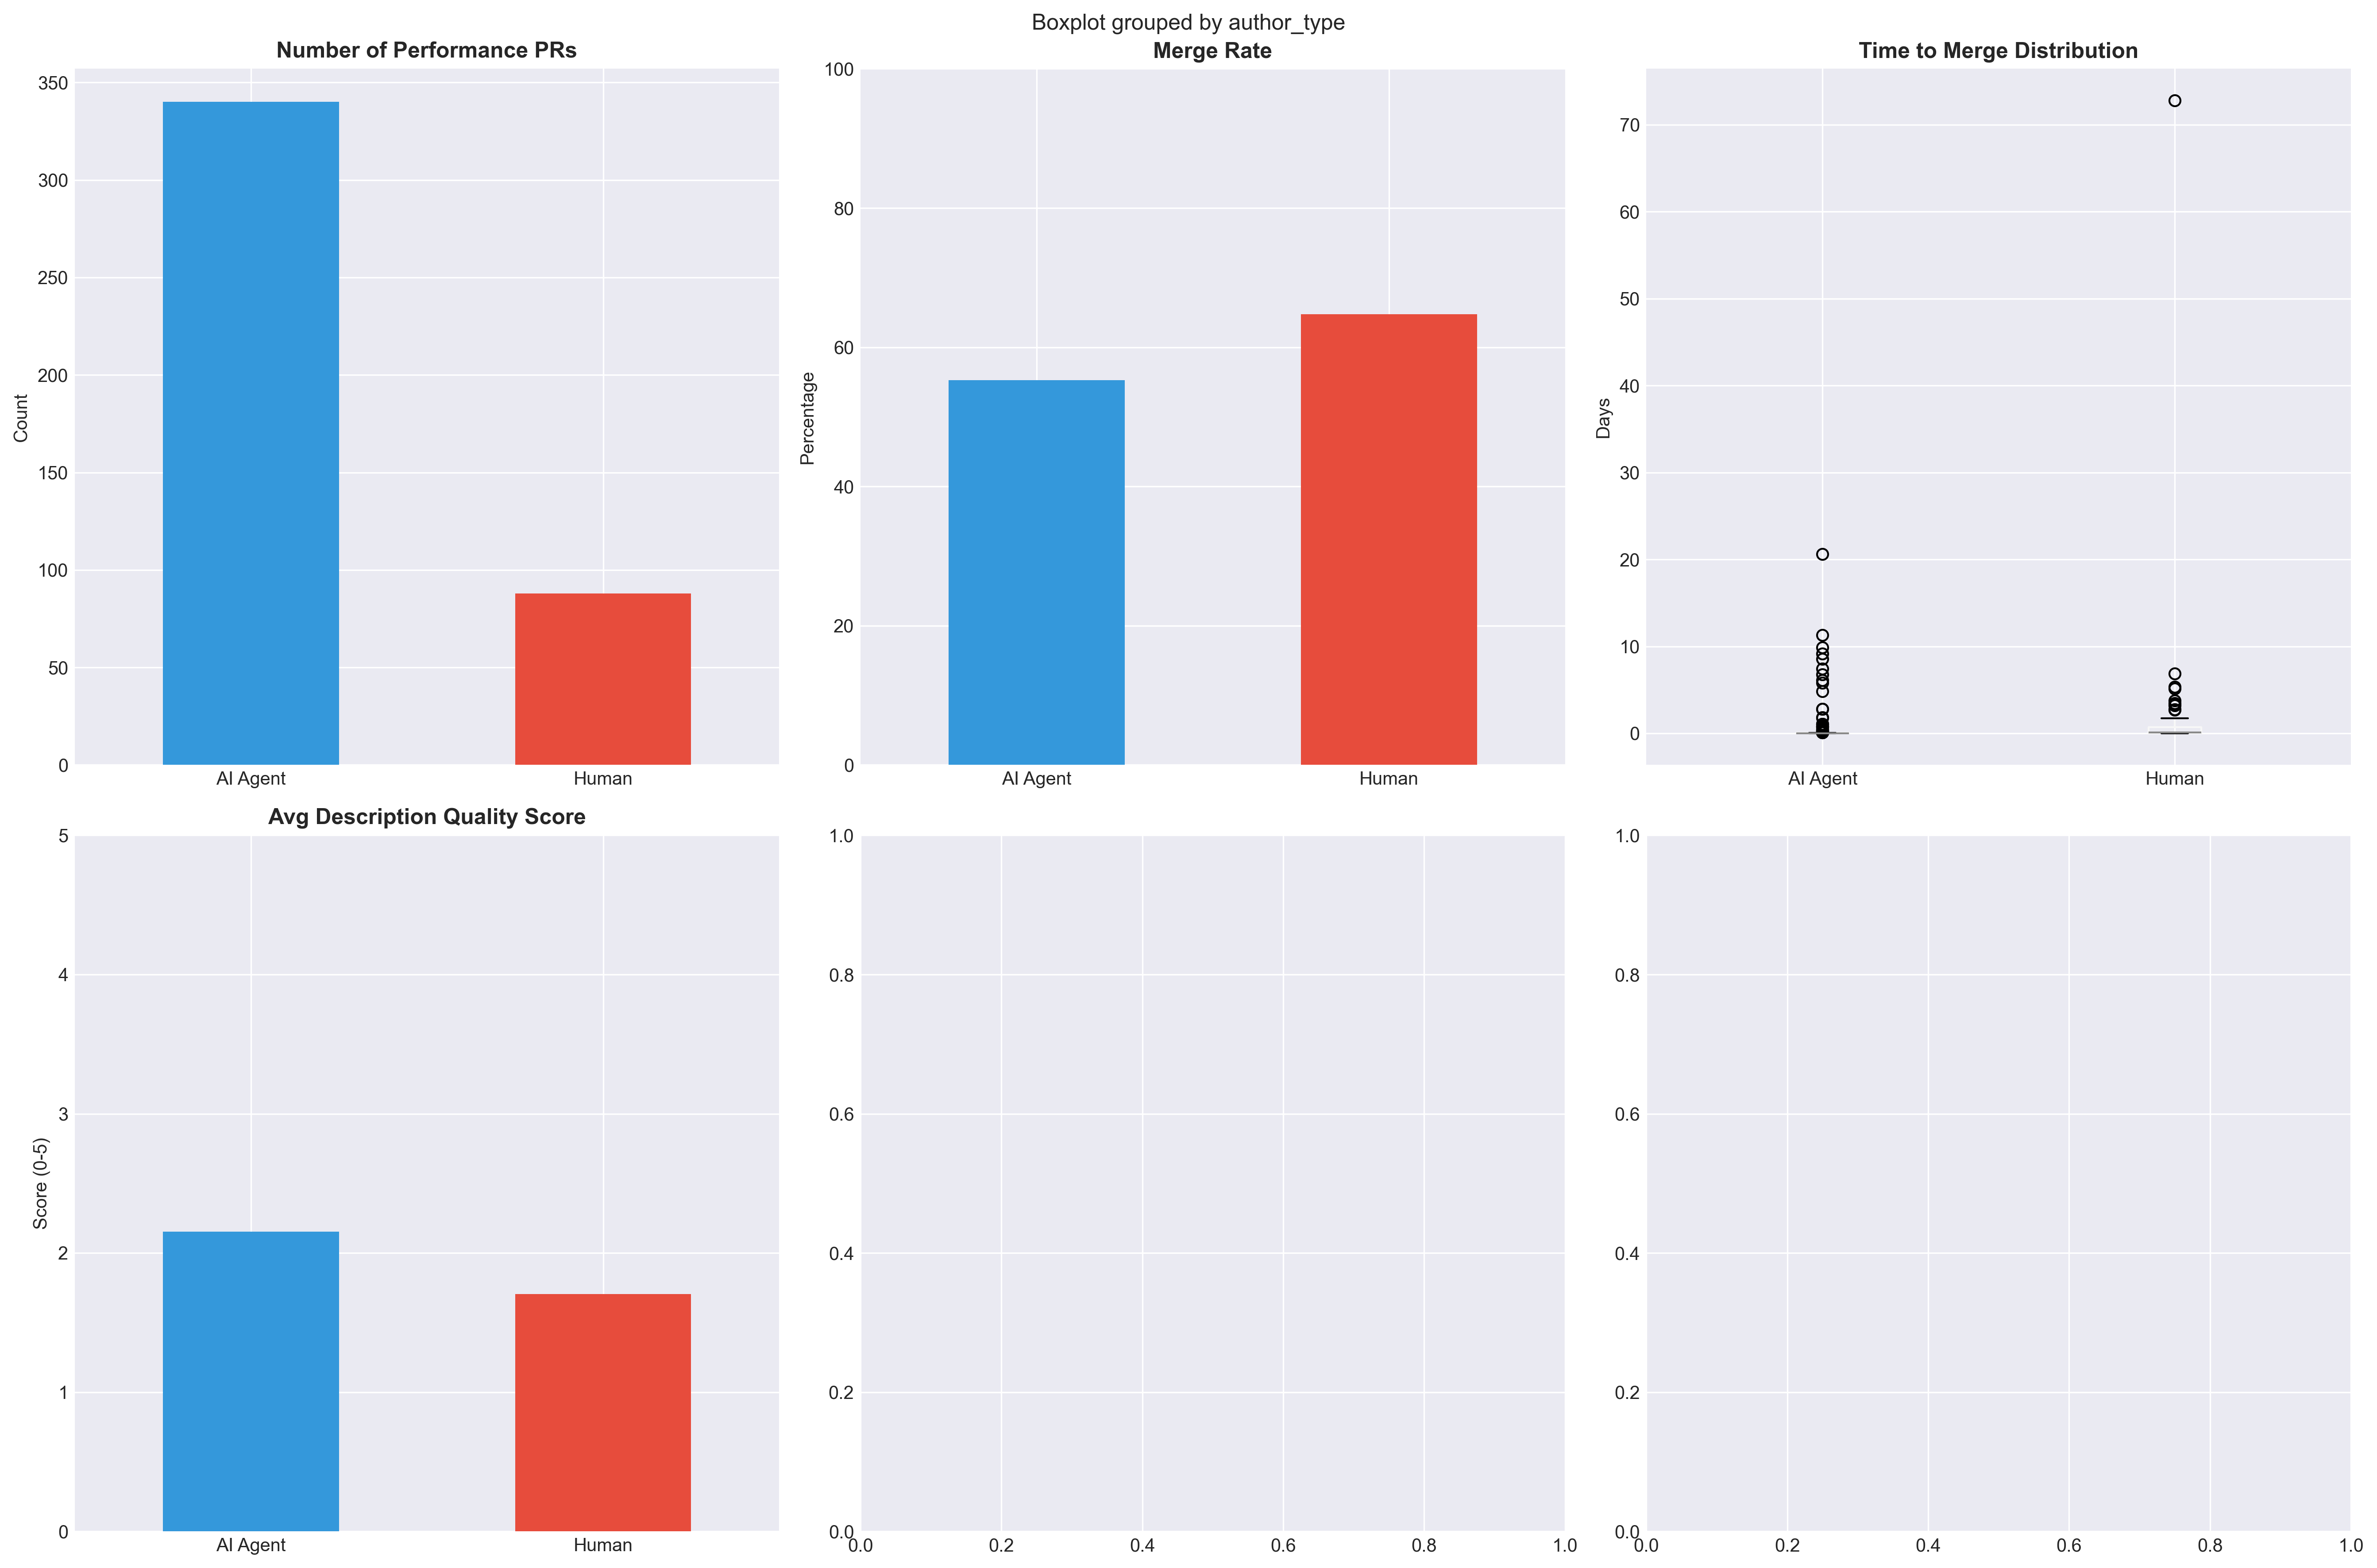

✓ Saved: ai_vs_human_overview.png


In [64]:
# Visualize high-level comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Sample size
perf_prs.groupby('author_type').size().plot(kind='bar', ax=axes[0,0], color=['#3498db', '#e74c3c'])
axes[0,0].set_title('Number of Performance PRs', fontweight='bold', fontsize=12)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Merge rate
merge_rates = perf_prs.groupby('author_type')['is_merged'].mean() * 100
merge_rates.plot(kind='bar', ax=axes[0,1], color=['#3498db', '#e74c3c'])
axes[0,1].set_title('Merge Rate', fontweight='bold', fontsize=12)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Percentage')
axes[0,1].set_ylim(0, 100)
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Time to merge
merged_prs = perf_prs[perf_prs['is_merged']]
merged_prs.boxplot(column='time_to_merge_days', by='author_type', ax=axes[0,2])
axes[0,2].set_title('Time to Merge Distribution', fontweight='bold', fontsize=12)
axes[0,2].set_xlabel('')
axes[0,2].set_ylabel('Days')
plt.sca(axes[0,2])
plt.xticks(rotation=0)

# 4. Description quality
quality_scores = perf_prs.groupby('author_type')['description_quality_score'].mean()
quality_scores.plot(kind='bar', ax=axes[1,0], color=['#3498db', '#e74c3c'])
axes[1,0].set_title('Avg Description Quality Score', fontweight='bold', fontsize=12)
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Score (0-5)')
axes[1,0].set_ylim(0, 5)
axes[1,0].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('results/ai_vs_human_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: ai_vs_human_overview.png")

# RQ1: Adoption and Practices

Analyzing PR size, description quality, and language usage patterns.

## RQ1.1: PR Size and Success

PR Size vs Success (AI vs Humans):
                                Count  Merge Rate (%)  Median Time (hrs)
author_type pr_size_category                                            
AI Agent    Small (<500)          201           70.00               0.01
            Medium (500-1500)      55           45.00               2.41
            Large (1500-5000)      74           27.00               7.05
            Very Large (>5000)      7           29.00             110.56
Human       Small (<500)           33           67.00               2.52
            Medium (500-1500)      19           74.00               2.47
            Large (1500-5000)      14           43.00               4.31
            Very Large (>5000)      8           38.00             123.22


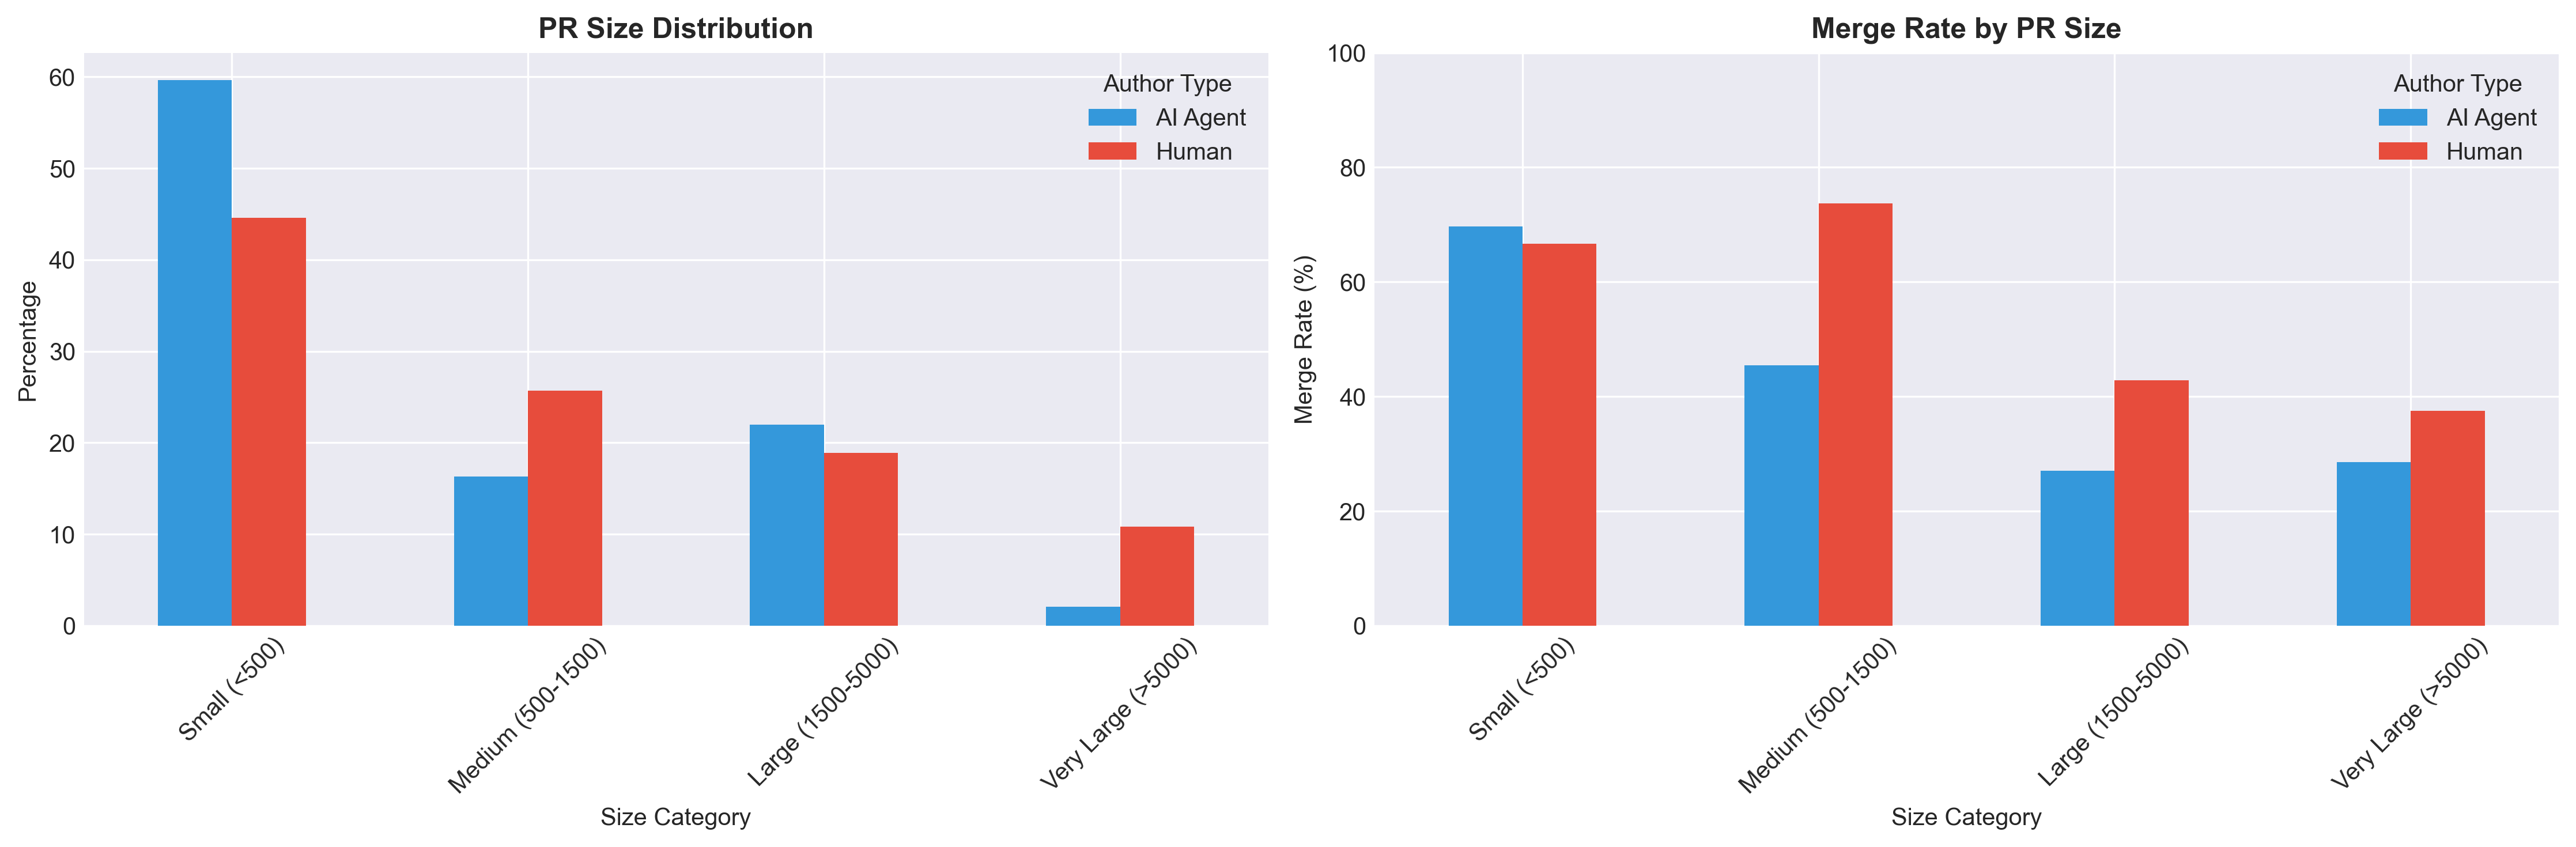

In [67]:
# Categorize by size
perf_prs['pr_size_category'] = pd.cut(
    perf_prs['body_length'],
    bins=[0, 500, 1500, 5000, float('inf')],
    labels=['Small (<500)', 'Medium (500-1500)', 'Large (1500-5000)', 'Very Large (>5000)']
)

# Analyze by author type and size
size_analysis = perf_prs.groupby(['author_type', 'pr_size_category'], observed=True).agg({
    'id': 'count',
    'is_merged': 'mean',
    'time_to_merge_hours': 'median'
}).round(2)

size_analysis.columns = ['Count', 'Merge Rate', 'Median Time (hrs)']
size_analysis['Merge Rate (%)'] = (size_analysis['Merge Rate'] * 100).round(1)

print("PR Size vs Success (AI vs Humans):")
print("="*80)
print(size_analysis[['Count', 'Merge Rate (%)', 'Median Time (hrs)']])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Size distribution
size_dist = pd.crosstab(perf_prs['author_type'], perf_prs['pr_size_category'], normalize='index') * 100
size_dist.T.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('PR Size Distribution', fontweight='bold')
axes[0].set_xlabel('Size Category')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Author Type')
axes[0].tick_params(axis='x', rotation=45)

# Merge rate by size
merge_by_size = perf_prs.groupby(['author_type', 'pr_size_category'], observed=True)['is_merged'].mean() * 100
merge_by_size.unstack().T.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'])
axes[1].set_title('Merge Rate by PR Size', fontweight='bold')
axes[1].set_xlabel('Size Category')
axes[1].set_ylabel('Merge Rate (%)')
axes[1].set_ylim(0, 100)
axes[1].legend(title='Author Type')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('results/rq1/rq1_pr_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## RQ1.2: Description Quality Impact

Description Quality Score vs Merge Rate:
                                       Count  Merge Rate (%)
author_type description_quality_score                       
AI Agent    0                             17           29.40
            1                             97           67.00
            2                             95           65.30
            3                             79           53.20
            4                             52           26.90
Human       0                             26           76.90
            1                             14           71.40
            2                             20           60.00
            3                             16           56.20
            4                             12           50.00

AI Agent - Quality ↔ Merge correlation: -0.175

Human - Quality ↔ Merge correlation: -0.206


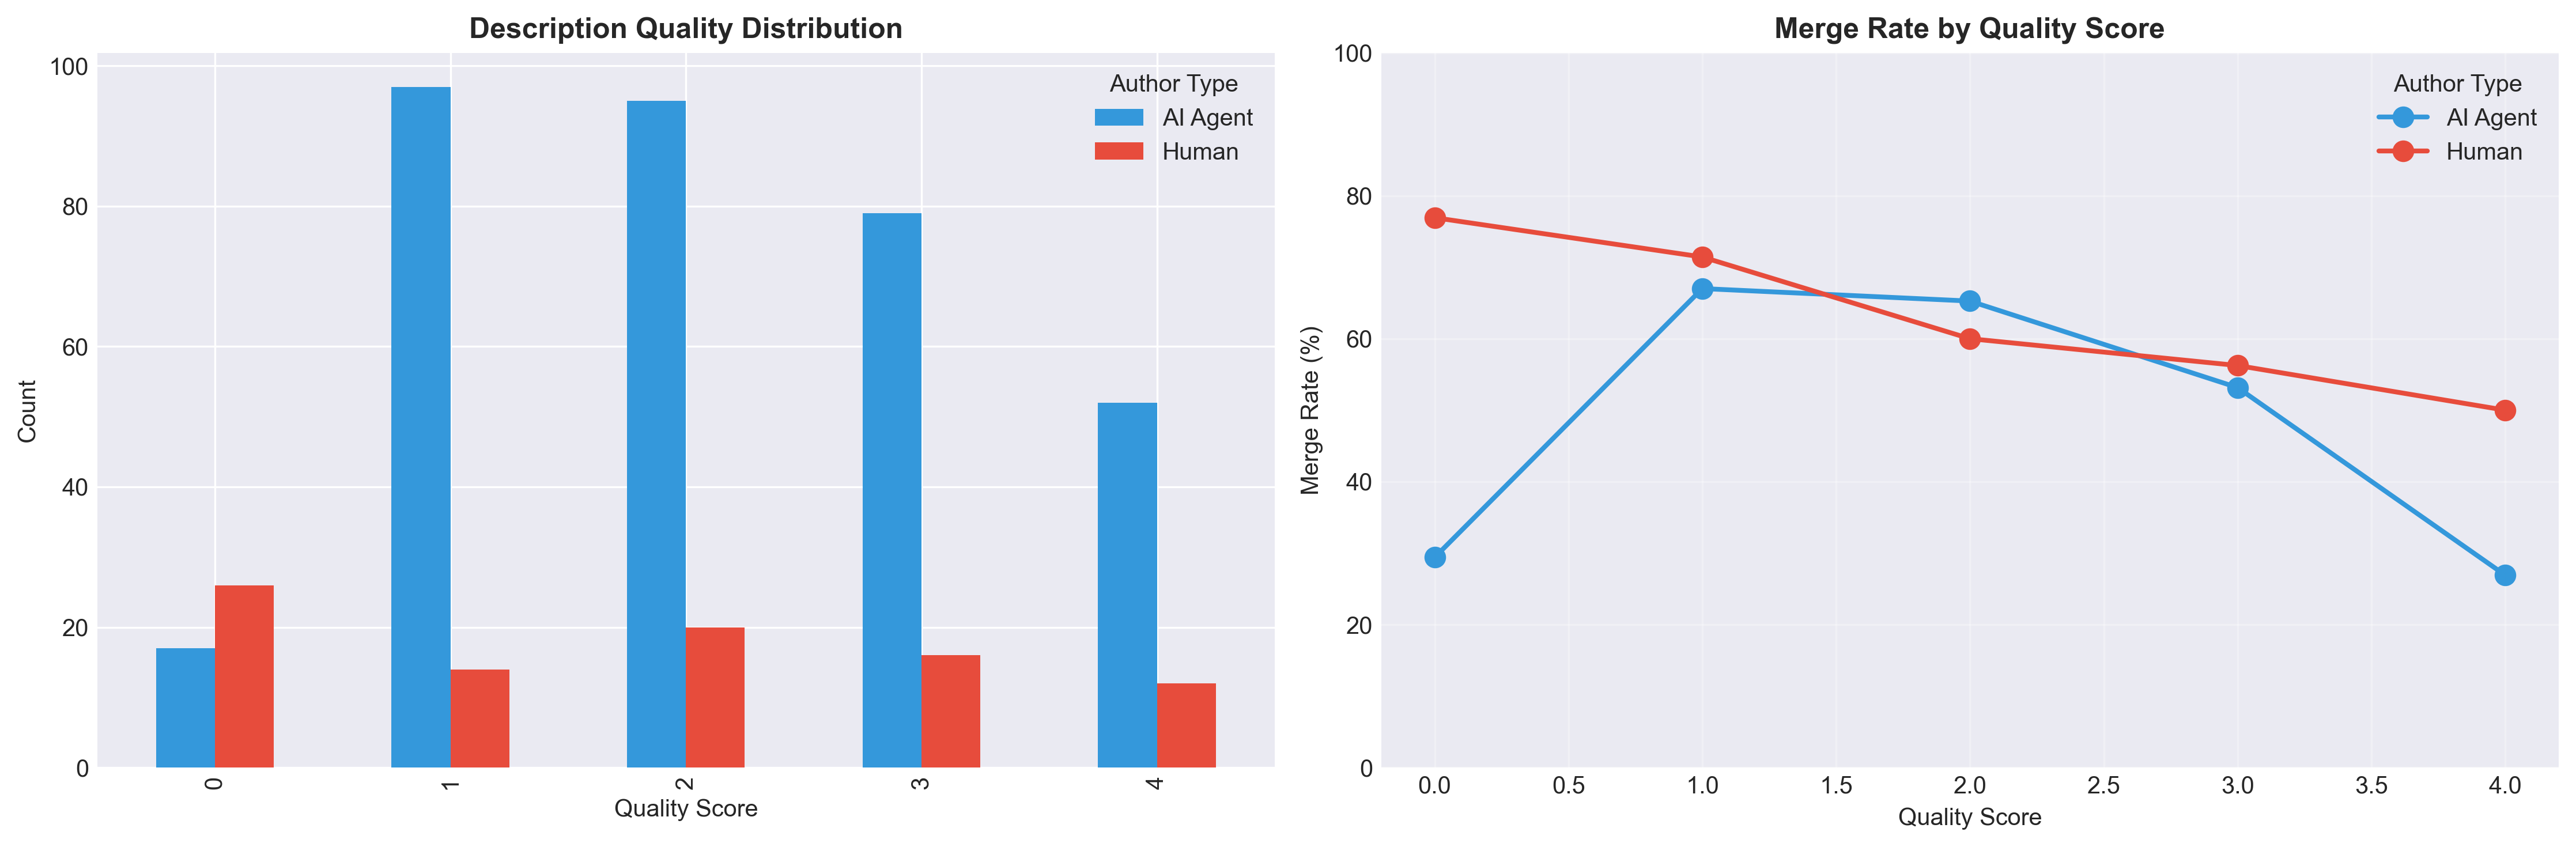

In [69]:
# Quality score distribution
quality_comparison = perf_prs.groupby(['author_type', 'description_quality_score']).agg({
    'id': 'count',
    'is_merged': 'mean'
}).round(3)

quality_comparison.columns = ['Count', 'Merge Rate']
quality_comparison['Merge Rate (%)'] = (quality_comparison['Merge Rate'] * 100).round(1)

print("Description Quality Score vs Merge Rate:")
print("="*80)
print(quality_comparison[['Count', 'Merge Rate (%)']])

# Statistical test
for author_type in ['AI Agent', 'Human']:
    subset = perf_prs[perf_prs['author_type'] == author_type]
    corr = subset[['description_quality_score', 'is_merged']].corr().iloc[0, 1]
    print(f"\n{author_type} - Quality ↔ Merge correlation: {corr:.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Quality score distribution
perf_prs.groupby(['author_type', 'description_quality_score']).size().unstack(fill_value=0).T.plot(
    kind='bar', ax=axes[0], color=['#3498db', '#e74c3c']
)
axes[0].set_title('Description Quality Distribution', fontweight='bold')
axes[0].set_xlabel('Quality Score')
axes[0].set_ylabel('Count')
axes[0].legend(title='Author Type')

# Merge rate by quality
(perf_prs.groupby(['author_type', 'description_quality_score'])['is_merged'].mean().unstack() * 100).T.plot(
    kind='line', marker='o', ax=axes[1], color=['#3498db', '#e74c3c'], linewidth=2, markersize=8
)
axes[1].set_title('Merge Rate by Quality Score', fontweight='bold')
axes[1].set_xlabel('Quality Score')
axes[1].set_ylabel('Merge Rate (%)')
axes[1].set_ylim(0, 100)
axes[1].legend(title='Author Type')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/rq1/rq1_quality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## RQ1.3: Programming Language Analysis

Top 10 Languages by Author Type:

AI Agent:
  Go               120 ( 35.3%) - Merge: 72.5%
  TypeScript        71 ( 20.9%) - Merge: 42.3%
  Python            41 ( 12.1%) - Merge: 46.3%
  C#                24 (  7.1%) - Merge: 58.3%
  JavaScript        13 (  3.8%) - Merge: 76.9%
  Java              13 (  3.8%) - Merge: 53.8%
  Rust              12 (  3.5%) - Merge: 16.7%
  Kotlin             8 (  2.4%) - Merge: 75.0%
  C++                7 (  2.1%) - Merge: 0.0%
  MoonBit            6 (  1.8%) - Merge: 66.7%

Human:
  Python            22 ( 25.0%) - Merge: 54.5%
  TypeScript        21 ( 23.9%) - Merge: 61.9%
  Rust               9 ( 10.2%) - Merge: 88.9%
  Go                 7 (  8.0%) - Merge: 85.7%
  Ruby               6 (  6.8%) - Merge: 83.3%
  C#                 5 (  5.7%) - Merge: 80.0%
  Java               4 (  4.5%) - Merge: 50.0%
  Zig                3 (  3.4%) - Merge: 66.7%
  HTML               2 (  2.3%) - Merge: 50.0%
  F#                 2 (  2.3%) - Merge: 50.0%


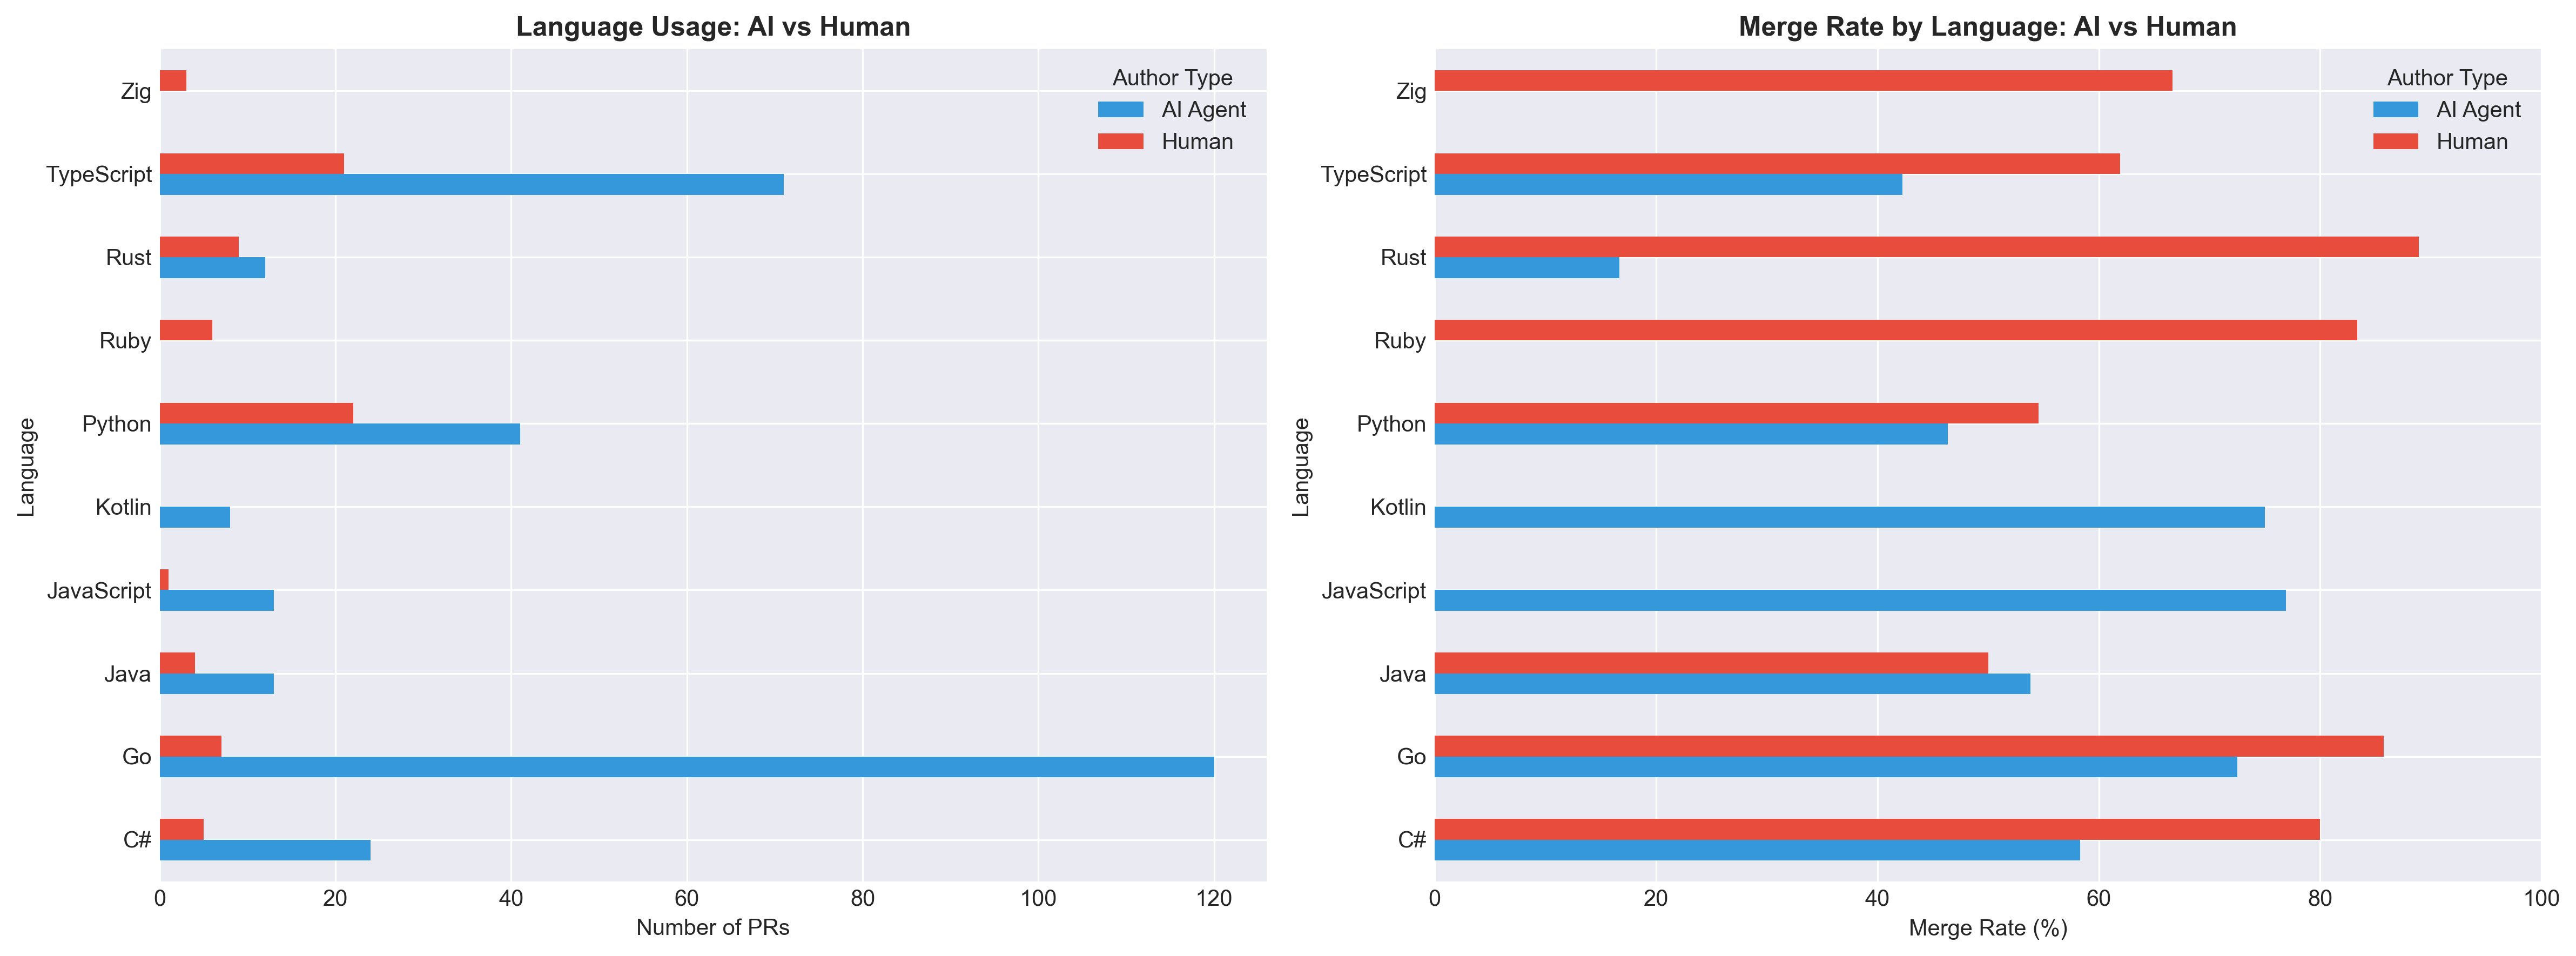

In [71]:
# Language frequency by author type
print("Top 10 Languages by Author Type:")
print("="*80)

for author_type in ['AI Agent', 'Human']:
    subset = perf_prs[perf_prs['author_type'] == author_type]
    lang_counts = subset['primary_language'].value_counts().head(10)
    
    print(f"\n{author_type}:")
    for lang, count in lang_counts.items():
        pct = count / len(subset) * 100
        merge_rate = subset[subset['primary_language'] == lang]['is_merged'].mean() * 100
        print(f"  {lang:15s} {count:4d} ({pct:5.1f}%) - Merge: {merge_rate:.1f}%")

# Compare top languages
all_top_langs = list(set(
    perf_prs[perf_prs['author_type'] == 'AI Agent']['primary_language'].value_counts().head(8).index.tolist() +
    perf_prs[perf_prs['author_type'] == 'Human']['primary_language'].value_counts().head(8).index.tolist()
))

lang_comparison = []
for lang in all_top_langs:
    for author_type in ['AI Agent', 'Human']:
        subset = perf_prs[(perf_prs['author_type'] == author_type) & (perf_prs['primary_language'] == lang)]
        if len(subset) > 0:
            lang_comparison.append({
                'Language': lang,
                'Author Type': author_type,
                'Count': len(subset),
                'Merge Rate (%)': subset['is_merged'].mean() * 100
            })

lang_df = pd.DataFrame(lang_comparison)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count comparison
lang_pivot_count = lang_df.pivot(index='Language', columns='Author Type', values='Count').fillna(0)
lang_pivot_count.plot(kind='barh', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Language Usage: AI vs Human', fontweight='bold')
axes[0].set_xlabel('Number of PRs')
axes[0].legend(title='Author Type')

# Merge rate comparison
lang_pivot_merge = lang_df.pivot(index='Language', columns='Author Type', values='Merge Rate (%)')
lang_pivot_merge.plot(kind='barh', ax=axes[1], color=['#3498db', '#e74c3c'])
axes[1].set_title('Merge Rate by Language: AI vs Human', fontweight='bold')
axes[1].set_xlabel('Merge Rate (%)')
axes[1].set_xlim(0, 100)
axes[1].legend(title='Author Type')

plt.tight_layout()
plt.savefig('results/rq1/rq1_language_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# RQ2: Optimization Patch Characteristics

In [72]:
# ============================================================================
# RQ2: Optimization Patch Characteristics
# ============================================================================

print("="*80)
print("OPTIMIZATION PATTERN ANALYSIS")
print("="*80)

# Filter PRs with successful GPT analysis
analyzed = perf_prs[perf_prs['gpt_success'] == True].copy()

print(f"\nAnalyzing {len(analyzed):,} PRs with GPT pattern classification")
print(f"  AI Agents: {(analyzed['author_type'] == 'AI Agent').sum():,}")
print(f"  Humans: {(analyzed['author_type'] == 'Human').sum():,}")

# Most common optimization patterns
print("\n" + "="*80)
print("Most Common Optimization Patterns:")
print("="*80)

for author_type in ['AI Agent', 'Human']:
    subset = analyzed[analyzed['author_type'] == author_type]
    pattern_counts = subset['optimization_pattern'].value_counts()
    
    print(f"\n{author_type} (top 10):")
    for pattern, count in pattern_counts.head(10).items():
        pct = count / len(subset) * 100
        pattern_short = pattern[:50] + '...' if len(pattern) > 50 else pattern
        print(f"  {pattern_short:52s} {count:4d} ({pct:5.1f}%)")

# Most common sub-patterns
print("\n" + "="*80)
print("Most Common Sub-Patterns:")
print("="*80)

for author_type in ['AI Agent', 'Human']:
    subset = analyzed[analyzed['author_type'] == author_type]
    subpattern_counts = subset['optimization_subpattern'].value_counts()
    
    print(f"\n{author_type} (top 10):")
    for subpattern, count in subpattern_counts.head(10).items():
        pct = count / len(subset) * 100
        subpattern_short = subpattern[:50] + '...' if len(subpattern) > 50 else subpattern
        print(f"  {subpattern_short:52s} {count:4d} ({pct:5.1f}%)")

# Pattern diversity comparison
print("\n" + "="*80)
print("Pattern Diversity Metrics:")
print("="*80)

diversity_stats = analyzed.groupby('author_type').agg({
    'optimization_pattern': ['nunique', 'count'],
    'optimization_subpattern': 'nunique'
}).round(2)

diversity_stats.columns = ['Unique Patterns', 'Total PRs', 'Unique Sub-Patterns']
diversity_stats['Patterns per PR'] = (diversity_stats['Unique Patterns'] / diversity_stats['Total PRs']).round(3)

print(diversity_stats)

# Statistical test for pattern diversity
ai_patterns = analyzed[analyzed['author_type'] == 'AI Agent']['optimization_pattern']
human_patterns = analyzed[analyzed['author_type'] == 'Human']['optimization_pattern']

# Pattern distribution comparison using Chi-square test
if len(ai_patterns) > 0 and len(human_patterns) > 0:
    # Get common patterns that appear in both groups
    common_patterns = set(ai_patterns.unique()) & set(human_patterns.unique())
    
    if len(common_patterns) > 1:
        # Filter to common patterns only
        ai_filtered = ai_patterns[ai_patterns.isin(common_patterns)]
        human_filtered = human_patterns[human_patterns.isin(common_patterns)]
        
        # Create contingency table
        pattern_crosstab = pd.crosstab(
            analyzed[analyzed['optimization_pattern'].isin(common_patterns)]['author_type'],
            analyzed[analyzed['optimization_pattern'].isin(common_patterns)]['optimization_pattern']
        )
        
        try:
            chi2, p_value = stats.chi2_contingency(pattern_crosstab)[:2]
            print(f"\nChi-square test (pattern distribution):")
            print(f"  Chi-square: {chi2:.4f}")
            print(f"  P-value: {p_value:.6f}")
            print(f"  Significant: {'✓ Yes' if p_value < 0.05 else '✗ No'} (α=0.05)")
            
            if p_value < 0.05:
                print(f"  → AI agents and humans show significantly different pattern preferences")
            else:
                print(f"  → AI agents and humans show similar pattern distributions")
        except:
            print("\n⚠ Unable to perform chi-square test (insufficient data)")

# Pattern co-occurrence analysis
print("\n" + "="*80)
print("Key Insights:")
print("="*80)

for author_type in ['AI Agent', 'Human']:
    subset = analyzed[analyzed['author_type'] == author_type]
    
    print(f"\n{author_type}:")
    
    # Most common pattern
    top_pattern = subset['optimization_pattern'].value_counts().index[0]
    top_count = subset['optimization_pattern'].value_counts().values[0]
    print(f"  Most common pattern: {top_pattern}")
    print(f"    {top_count} PRs ({top_count/len(subset)*100:.1f}%)")
    
    # Most common sub-pattern
    top_subpattern = subset['optimization_subpattern'].value_counts().index[0]
    top_sub_count = subset['optimization_subpattern'].value_counts().values[0]
    print(f"  Most common sub-pattern: {top_subpattern}")
    print(f"    {top_sub_count} PRs ({top_sub_count/len(subset)*100:.1f}%)")
    
    # Pattern diversity
    unique_patterns = subset['optimization_pattern'].nunique()
    unique_subpatterns = subset['optimization_subpattern'].nunique()
    print(f"  Pattern diversity: {unique_patterns} patterns, {unique_subpatterns} sub-patterns")

print("\n" + "="*80)

OPTIMIZATION PATTERN ANALYSIS

Analyzing 428 PRs with GPT pattern classification
  AI Agents: 340
  Humans: 88

Most Common Optimization Patterns:

AI Agent (top 10):
  Code Smells and Structural Simplification             107 ( 31.5%)
  Algorithm-Level Optimizations                         102 ( 30.0%)
  Memory and Data Locality Optimizations                 85 ( 25.0%)
  Control-Flow and Branching Optimizations               25 (  7.4%)
  No Meaningful Change                                   11 (  3.2%)
  Data Structure Selection and Adaptation                 6 (  1.8%)
  I/O and Synchronization                                 4 (  1.2%)

Human (top 10):
  Code Smells and Structural Simplification              31 ( 35.2%)
  Memory and Data Locality Optimizations                 24 ( 27.3%)
  Algorithm-Level Optimizations                          21 ( 23.9%)
  Control-Flow and Branching Optimizations                5 (  5.7%)
  Data Structure Selection and Adaptation                

# RQ3: Testing and Evaluation Behavior [TODO]

# RQ4: Review Dynamics

Review Time Statistics (Merged PRs):
             count  mean    std  min  25%  50%   75%     max
author_type                                                 
AI Agent    188.00 14.21  54.52 0.00 0.00 0.03  0.72  494.23
Human        57.00 51.12 231.63 0.00 0.51 2.27 17.25 1747.19

Mann-Whitney U test (time to merge):
  AI Agent median: 0.0 hours (0.0 days)
  Human median: 2.3 hours (0.1 days)
  P-value: 0.000000
  Significant: Yes (α=0.05)


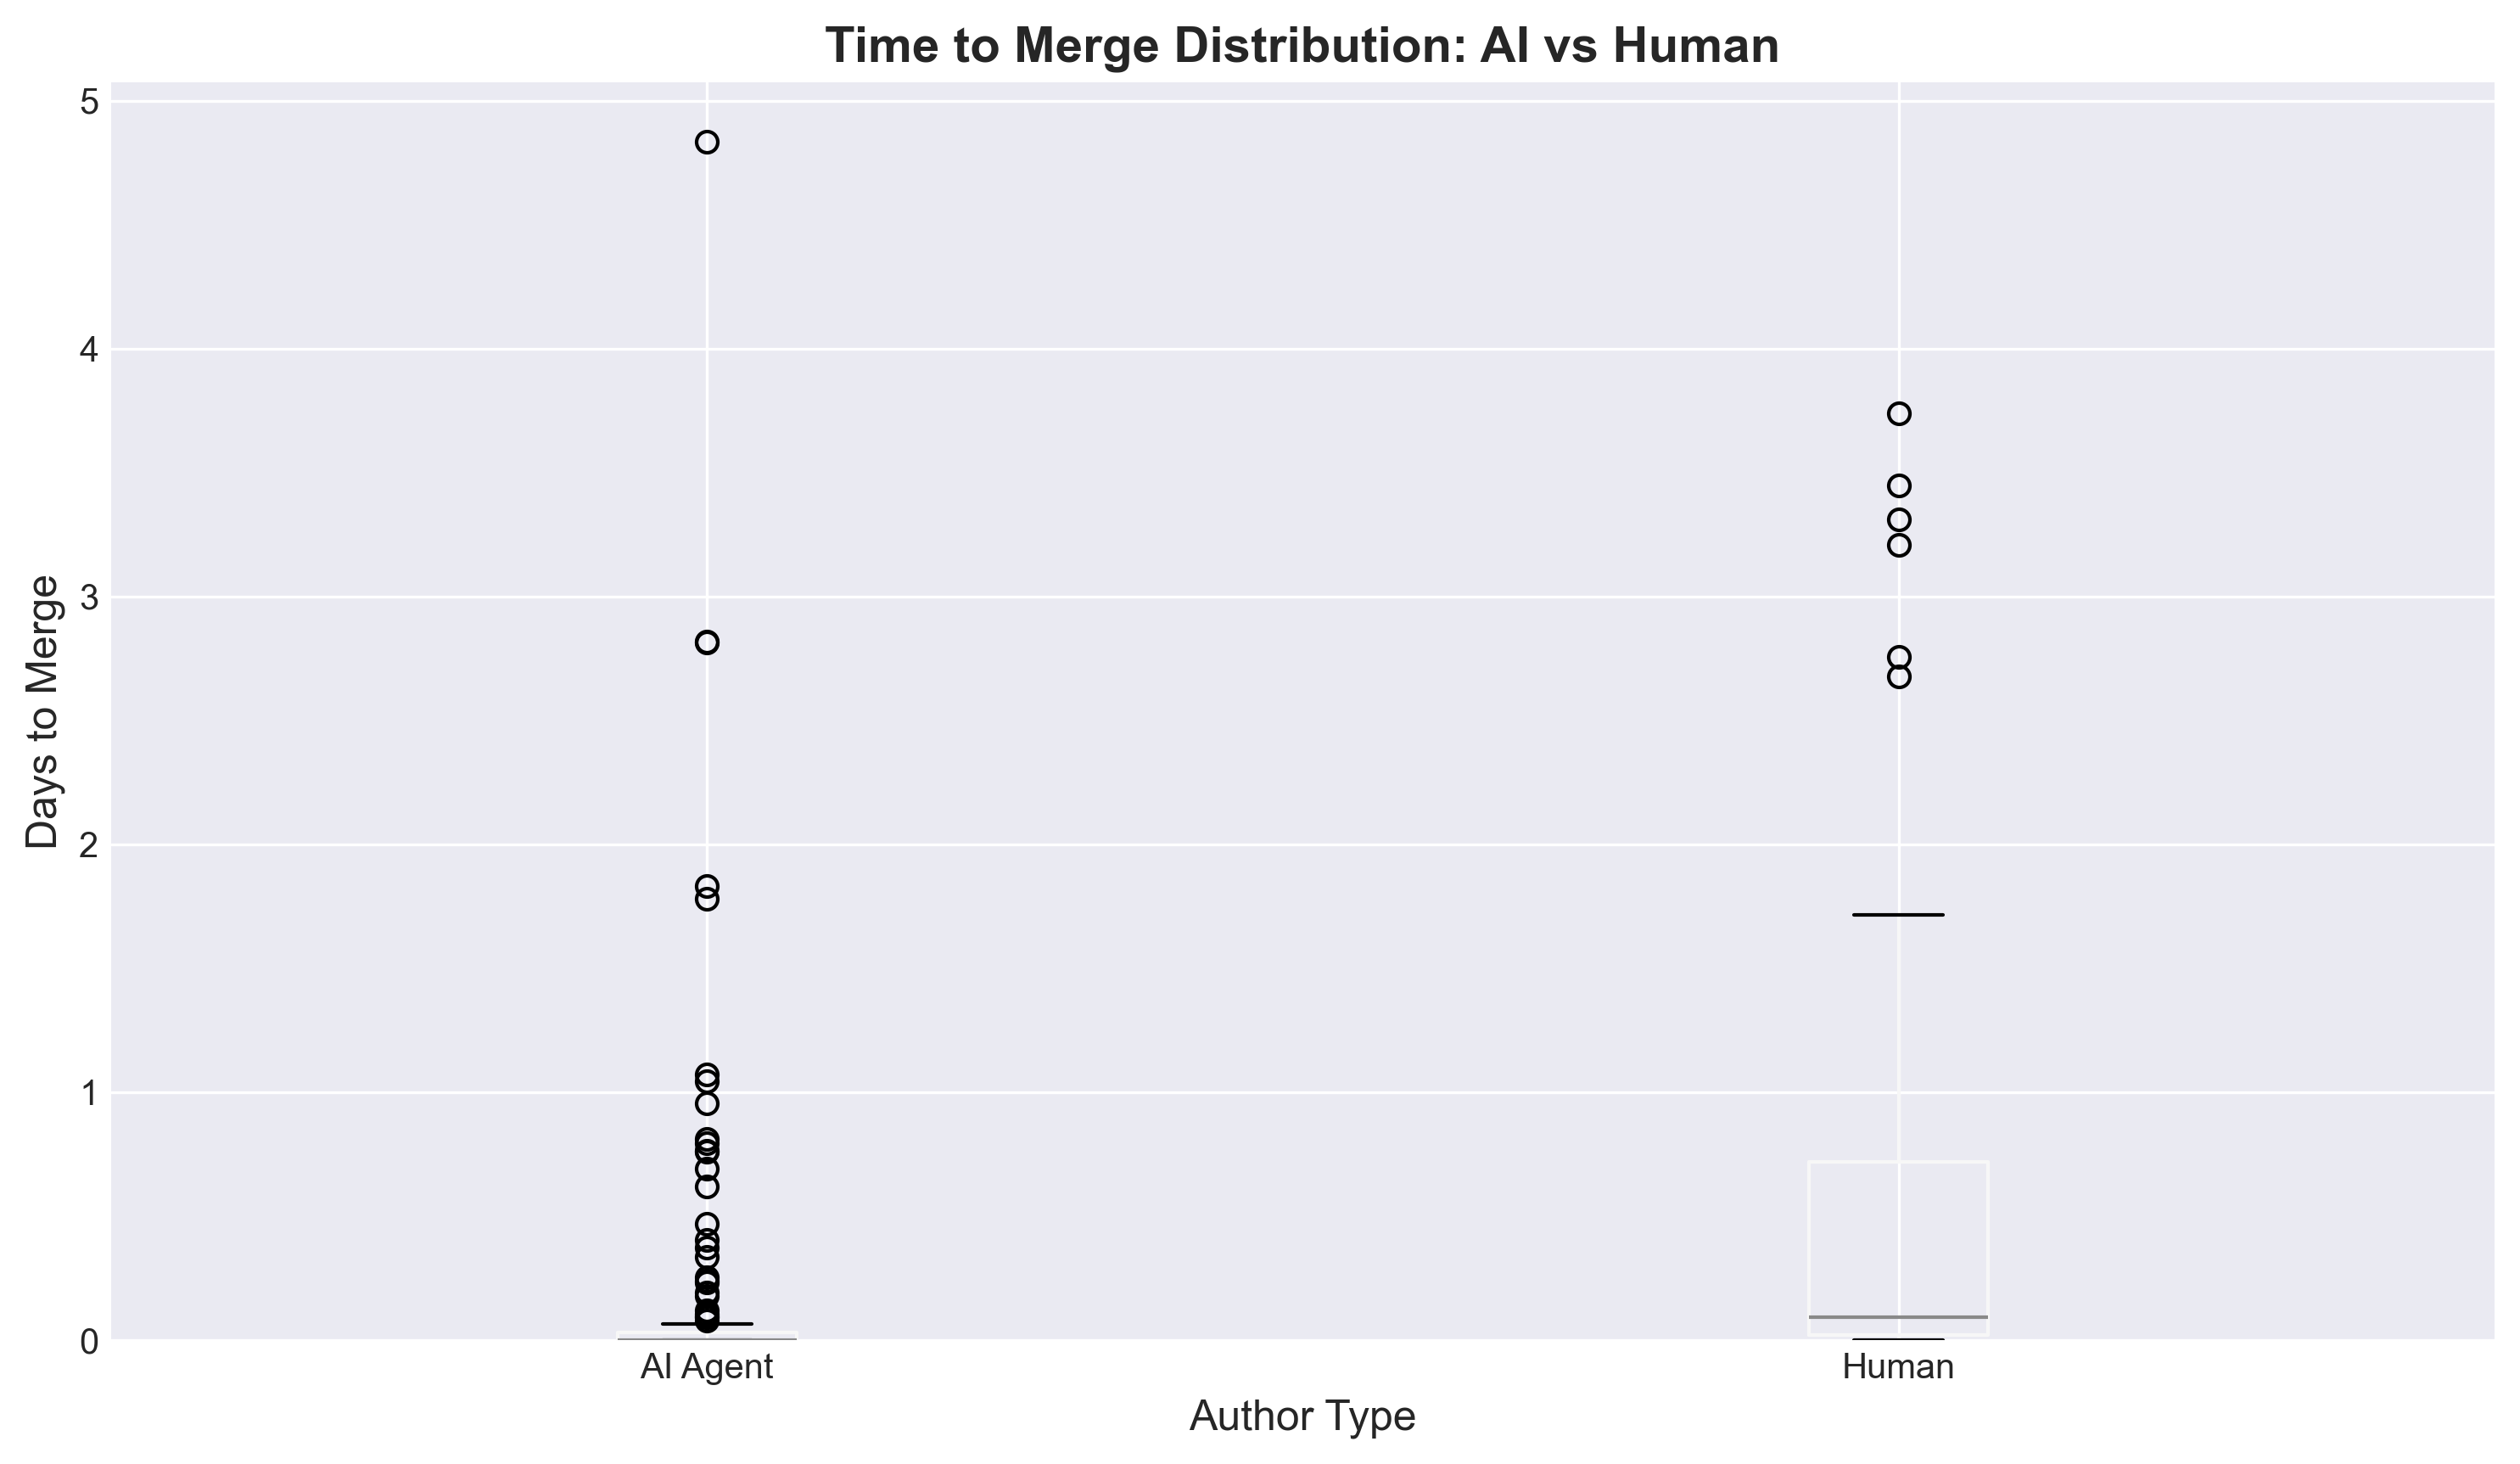

In [74]:
# Review time analysis
merged_prs = perf_prs[perf_prs['is_merged']].copy()

review_stats = merged_prs.groupby('author_type')['time_to_merge_hours'].describe()
print("Review Time Statistics (Merged PRs):")
print("="*80)
print(review_stats)

# Statistical test
ai_times = merged_prs[merged_prs['author_type'] == 'AI Agent']['time_to_merge_hours'].dropna()
human_times = merged_prs[merged_prs['author_type'] == 'Human']['time_to_merge_hours'].dropna()

if len(ai_times) > 0 and len(human_times) > 0:
    statistic, p_value = stats.mannwhitneyu(ai_times, human_times, alternative='two-sided')
    print(f"\nMann-Whitney U test (time to merge):")
    print(f"  AI Agent median: {ai_times.median():.1f} hours ({ai_times.median()/24:.1f} days)")
    print(f"  Human median: {human_times.median():.1f} hours ({human_times.median()/24:.1f} days)")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
merged_prs.boxplot(column='time_to_merge_days', by='author_type', ax=ax)
ax.set_title('Time to Merge Distribution: AI vs Human', fontweight='bold', fontsize=14)
ax.set_xlabel('Author Type', fontsize=12)
ax.set_ylabel('Days to Merge', fontsize=12)
ax.set_ylim(0, merged_prs['time_to_merge_days'].quantile(0.95))
plt.suptitle('')
plt.tight_layout()
plt.savefig('results/rq4/rq4_review_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# RQ5: Failure Patterns [Needs to update]

In [75]:
# Failure analysis
failed_prs = perf_prs[(perf_prs['state'] == 'closed') & (~perf_prs['is_merged'])].copy()
successful_prs = perf_prs[perf_prs['is_merged']].copy()

print("Failure Analysis by Author Type:")
print("="*80)

failure_stats = perf_prs.groupby('author_type').agg({
    'id': 'count',
    'is_merged': 'mean'
}).round(3)
failure_stats.columns = ['Total', 'Success Rate']
failure_stats['Failure Rate (%)'] = ((1 - failure_stats['Success Rate']) * 100).round(1)

print(failure_stats[['Total', 'Failure Rate (%)']])

# Characteristic comparison
comparison = []
for author_type in ['AI Agent', 'Human']:
    success = successful_prs[successful_prs['author_type'] == author_type]
    fail = failed_prs[failed_prs['author_type'] == author_type]
    
    comparison.append({
        'Author Type': author_type,
        'Outcome': 'Successful',
        'Avg Body Length': success['body_length'].mean(),
        'Has Body (%)': success['has_body'].mean() * 100,
        'Avg Quality Score': success['description_quality_score'].mean(),
    })
    
    if len(fail) > 0:
        comparison.append({
            'Author Type': author_type,
            'Outcome': 'Failed',
            'Avg Body Length': fail['body_length'].mean(),
            'Has Body (%)': fail['has_body'].mean() * 100,
            'Avg Quality Score': fail['description_quality_score'].mean(),
        })

comparison_df = pd.DataFrame(comparison).round(2)

print("\nCharacteristic Comparison: Successful vs Failed PRs")
print("="*80)
print(comparison_df)

# Key risk factors
print("\n" + "="*80)
print("KEY RISK FACTORS:")

for author_type in ['AI Agent', 'Human']:
    subset = perf_prs[perf_prs['author_type'] == author_type]
    print(f"\n{author_type}:")
    
    # Missing description
    no_body_fail = 1 - subset[~subset['has_body']]['is_merged'].mean()
    has_body_fail = 1 - subset[subset['has_body']]['is_merged'].mean()
    if not pd.isna(no_body_fail) and not pd.isna(has_body_fail):
        print(f"  Missing description: +{(no_body_fail - has_body_fail)*100:.1f}% failure rate")
    
    # Low quality
    low_qual = subset[subset['description_quality_score'] < 2]
    high_qual = subset[subset['description_quality_score'] >= 3]
    if len(low_qual) > 0 and len(high_qual) > 0:
        low_fail = 1 - low_qual['is_merged'].mean()
        high_fail = 1 - high_qual['is_merged'].mean()
        print(f"  Low quality (score <2): +{(low_fail - high_fail)*100:.1f}% failure rate")

Failure Analysis by Author Type:
             Total  Failure Rate (%)
author_type                         
AI Agent       340             44.70
Human           88             35.20

Characteristic Comparison: Successful vs Failed PRs
  Author Type     Outcome  Avg Body Length  Has Body (%)  Avg Quality Score
0    AI Agent  Successful           693.26         99.47               1.97
1    AI Agent      Failed          1737.17        100.00               2.38
2       Human  Successful          1329.53         78.95               1.49
3       Human      Failed          4201.59         94.44               1.94

KEY RISK FACTORS:

AI Agent:
  Missing description: +22.2% failure rate
  Low quality (score <2): +-18.7% failure rate

Human:
  Missing description: +-24.9% failure rate
  Low quality (score <2): +-21.4% failure rate


# Summary

In [76]:
print("="*100)
print("PERFORMANCE PR ANALYSIS: KEY FINDINGS")
print("="*100)

# Calculate key metrics
ai_stats = perf_prs[perf_prs['author_type'] == 'AI Agent']
human_stats = perf_prs[perf_prs['author_type'] == 'Human']

print(f"\n1. OVERALL SUCCESS")
print(f"   AI Agents: {ai_stats['is_merged'].mean()*100:.1f}% merge rate ({ai_stats['is_merged'].sum():,}/{len(ai_stats):,})")
print(f"   Humans: {human_stats['is_merged'].mean()*100:.1f}% merge rate ({human_stats['is_merged'].sum():,}/{len(human_stats):,})")
diff = ai_stats['is_merged'].mean() - human_stats['is_merged'].mean()
print(f"   Difference: {'+' if diff > 0 else ''}{diff*100:.1f}% points")

print(f"\n2. DESCRIPTION QUALITY")
print(f"   AI Agents: {ai_stats['description_quality_score'].mean():.2f}/5 avg quality")
print(f"   Humans: {human_stats['description_quality_score'].mean():.2f}/5 avg quality")
print(f"   AI with detailed descriptions: {ai_stats['has_body'].mean()*100:.1f}%")
print(f"   Humans with detailed descriptions: {human_stats['has_body'].mean()*100:.1f}%")

print(f"\n3. TESTING & MEASUREMENT")
print(f"TODO: Add testing & measurement statistics here")

print(f"\n4. REVIEW TIME")
ai_merged = ai_stats[ai_stats['is_merged']]
human_merged = human_stats[human_stats['is_merged']]
if len(ai_merged) > 0:
    print(f"   AI Agents median: {ai_merged['time_to_merge_hours'].median():.1f} hours ({ai_merged['time_to_merge_days'].median():.1f} days)")
if len(human_merged) > 0:
    print(f"   Humans median: {human_merged['time_to_merge_hours'].median():.1f} hours ({human_merged['time_to_merge_days'].median():.1f} days)")

print(f"\n5. TOP LANGUAGES")
print(f"   AI Agents: {', '.join(ai_stats['primary_language'].value_counts().head(3).index.tolist())}")
print(f"   Humans: {', '.join(human_stats['primary_language'].value_counts().head(3).index.tolist())}")

print("\n" + "="*100)

PERFORMANCE PR ANALYSIS: KEY FINDINGS

1. OVERALL SUCCESS
   AI Agents: 55.3% merge rate (188/340)
   Humans: 64.8% merge rate (57/88)
   Difference: -9.5% points

2. DESCRIPTION QUALITY
   AI Agents: 2.15/5 avg quality
   Humans: 1.70/5 avg quality
   AI with detailed descriptions: 99.1%
   Humans with detailed descriptions: 84.1%

3. TESTING & MEASUREMENT
TODO: Add testing & measurement statistics here

4. REVIEW TIME
   AI Agents median: 0.0 hours (0.0 days)
   Humans median: 2.3 hours (0.1 days)

5. TOP LANGUAGES
   AI Agents: Go, TypeScript, Python
   Humans: Python, TypeScript, Rust



## Export Results

In [ ]:
# Export datasets
raw_export_cols = [
    'id', 'number', 'title', 'body', 'classification_reason', 'agent', 'author_type',
    'state', 'created_at', 'merged_at', 'is_merged', 'primary_language', 'repo_id', 'html_url'
]

# Ground-truth subset (no engineered annotations)
perf_prs[raw_export_cols].to_csv('datasets/performance_prs_ai_vs_human_raw.csv', index=False)
print("✓ Exported: performance_prs_ai_vs_human_raw.csv (ground-truth subset)")

# Annotated dataset with engineered features
export_cols = [
    'id', 'number', 'title', 'body', 'classification_reason', 'agent', 'author_type', 'state',
    'created_at', 'merged_at', 'is_merged', 'time_to_merge_days',
    'primary_language', 'repo_id', 'html_url',
    'has_body', 'body_length', 'description_quality_score',
    'optimization_pattern', 'optimization_subpattern',
    'gpt_explanation', 'gpt_comparison'
]

perf_prs[export_cols].to_csv('results/performance_prs_ai_vs_human.csv', index=False)
print("✓ Exported: performance_prs_ai_vs_human.csv (annotated dataset)")

# Export summary statistics
comparison_stats.to_csv('results/summary_ai_vs_human.csv')
print("✓ Exported: summary_ai_vs_human.csv")

print("="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"Generated files:")
print(f"  • performance_prs_ai_vs_human_raw.csv - Ground-truth subset")
print(f"  • performance_prs_ai_vs_human.csv - Annotated dataset")
print(f"  • summary_ai_vs_human.csv - Summary statistics")
print(f"  • ai_vs_human_overview.png - Overview comparison")
print(f"  • rq1_pr_size_comparison.png - PR size analysis")
print(f"  • rq1_quality_comparison.png - Quality analysis")
print(f"  • rq1_language_comparison.png - Language analysis")
print(f"  • rq3_testing_comparison.png - Testing practices")
print(f"  • rq4_review_time_comparison.png - Review dynamics")
print(f"Total performance PRs analyzed: {len(perf_prs):,}")
print(f"  AI Agents: {len(ai_perf_prs):,}")
print(f"  Humans: {len(human_perf_prs):,}")

✓ Exported: performance_prs_ai_vs_human_raw.csv (ground-truth subset)
✓ Exported: performance_prs_ai_vs_human.csv (annotated dataset)
✓ Exported: summary_ai_vs_human.csv
ANALYSIS COMPLETE!
Generated files:
  • performance_prs_ai_vs_human_raw.csv - Ground-truth subset
  • performance_prs_ai_vs_human.csv - Annotated dataset
  • summary_ai_vs_human.csv - Summary statistics
  • ai_vs_human_overview.png - Overview comparison
  • rq1_pr_size_comparison.png - PR size analysis
  • rq1_quality_comparison.png - Quality analysis
  • rq1_language_comparison.png - Language analysis
  • rq3_testing_comparison.png - Testing practices
  • rq4_review_time_comparison.png - Review dynamics
Total performance PRs analyzed: 428
  AI Agents: 340
  Humans: 88
